## add segmentation from Aeroscapes

In [1]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd

from PIL import Image
from PIL import ImageFilter
import ast
import json
from glob import glob

In [2]:
#https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model

In [3]:
#https://github.com/tensorflow/addons/blob/v0.11.2/tensorflow_addons/image/__init__.py
from tensorflow_addons.image.color_ops import sharpness
from tensorflow_addons.image.filters import gaussian_filter2d
from tensorflow_addons.image.dense_image_warp import dense_image_warp

In [4]:
tf.__version__, tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


('2.3.1', True)

In [5]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #CPU

In [6]:
class_names = ['bg', 'person', 'bicycle', 'lean', 'car']

padded_image_shape = (1024, 1920)
anchor_k = 6
num_classes = 30
num_classes_real = len(class_names)
max_data_m = 50#00#0
use_zoom_up_data = False
use_pedestrian = False
use_visdrone = False
use_Aeroscapes = True
level_start = 4
level_end = 7
l1 = 1e-8 #1e-9
activation = 'swish'#'selu' is not converted to tflite
kernel_init = tf.initializers.he_normal()
edgecolors = np.random.rand(num_classes, 3) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)

In [7]:
num_classes_real

5

In [8]:
path_pedestrian = '/home/mvlab/Downloads/dataset/통영/'
forder_P_DESTRE = '/home/mvlab/Downloads/dataset/P-DESTRE/'
folder_weather = '/home/sogangori/Downloads/dataset/weather/'

names = ['fn','cname','id', 'x0', 'y0', 'w', 'h']
edgecolors = np.random.rand(num_classes, 3) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)
path_weight = "weight/pedestrian_efficientDet-D4"

os.path.isdir(path_pedestrian), os.path.isdir(forder_P_DESTRE)

(True, True)

In [9]:
paths_avi = glob(path_pedestrian+'*.avi')
paths_txt = glob(path_pedestrian+'*/*.txt')
paths_img = glob(path_pedestrian+'*/*')
len(paths_avi), len(paths_txt), len(paths_img)

(0, 36, 31176)

In [10]:
len(paths_txt), paths_txt#14

(36,
 ['/home/mvlab/Downloads/dataset/통영/20210204 IMAGE6/IMAGE6.txt',
  '/home/mvlab/Downloads/dataset/통영/20210203 IMAGE7/IMAGE6.txt',
  '/home/mvlab/Downloads/dataset/통영/20210204 IMAGE11/IMAGE11.txt',
  '/home/mvlab/Downloads/dataset/통영/미수2/미수2.txt',
  '/home/mvlab/Downloads/dataset/통영/20210127 이예진/미수_스마트시티_통영대교_미수방향2(Ch 01)_[20210125]133000-[20210125]135000(20210125_133001).txt',
  '/home/mvlab/Downloads/dataset/통영/IMAGE4/IMAGE2.txt',
  '/home/mvlab/Downloads/dataset/통영/20210203 IMAGE4/IMAGE4.txt',
  '/home/mvlab/Downloads/dataset/통영/IMAGE1/IMAGE fix.txt',
  '/home/mvlab/Downloads/dataset/통영/20210127 조윤선/미수_스마트시티_통영대교_미수방향1(Ch 01)_[20210127]103524-[20210127]104524(20210127_103524).txt',
  '/home/mvlab/Downloads/dataset/통영/미수1/미수1.txt',
  '/home/mvlab/Downloads/dataset/통영/IMAGE3/IMAGE3.txt',
  '/home/mvlab/Downloads/dataset/통영/20210203 IMAGE1/IMAGE1.txt',
  '/home/mvlab/Downloads/dataset/통영/도천1/도천1.txt',
  '/home/mvlab/Downloads/dataset/통영/20210203 IMAGE11/IMAGE10.txt',
  '/home/mvlab

In [11]:
use_weather_effect = os.path.isdir(folder_weather)
use_weather_effect, folder_weather

(False, '/home/sogangori/Downloads/dataset/weather/')

In [12]:
weather_images = []
if use_weather_effect:
    path_weathers = glob(folder_weather + '*.*')
    if len(path_weathers)>0:
        for path_weather in path_weathers:            
            image = Image.open(path_weather) 
            weather_images.append(image)            
            plt.imshow(image)
            plt.show()
    else:
        use_weather_effect = False

### video label load

In [13]:
paths_txt

['/home/mvlab/Downloads/dataset/통영/20210204 IMAGE6/IMAGE6.txt',
 '/home/mvlab/Downloads/dataset/통영/20210203 IMAGE7/IMAGE6.txt',
 '/home/mvlab/Downloads/dataset/통영/20210204 IMAGE11/IMAGE11.txt',
 '/home/mvlab/Downloads/dataset/통영/미수2/미수2.txt',
 '/home/mvlab/Downloads/dataset/통영/20210127 이예진/미수_스마트시티_통영대교_미수방향2(Ch 01)_[20210125]133000-[20210125]135000(20210125_133001).txt',
 '/home/mvlab/Downloads/dataset/통영/IMAGE4/IMAGE2.txt',
 '/home/mvlab/Downloads/dataset/통영/20210203 IMAGE4/IMAGE4.txt',
 '/home/mvlab/Downloads/dataset/통영/IMAGE1/IMAGE fix.txt',
 '/home/mvlab/Downloads/dataset/통영/20210127 조윤선/미수_스마트시티_통영대교_미수방향1(Ch 01)_[20210127]103524-[20210127]104524(20210127_103524).txt',
 '/home/mvlab/Downloads/dataset/통영/미수1/미수1.txt',
 '/home/mvlab/Downloads/dataset/통영/IMAGE3/IMAGE3.txt',
 '/home/mvlab/Downloads/dataset/통영/20210203 IMAGE1/IMAGE1.txt',
 '/home/mvlab/Downloads/dataset/통영/도천1/도천1.txt',
 '/home/mvlab/Downloads/dataset/통영/20210203 IMAGE11/IMAGE10.txt',
 '/home/mvlab/Downloads/dataset/통

In [14]:
list_df_TongYoung = []

for path_txt in paths_txt:
    df = pd.read_csv(path_txt, header=None, names=names)    
    index_last_sep = path_txt.rindex(os.sep)
    path_self_folder = path_txt[:index_last_sep+1]
    annot_file_name = path_txt.split(os.sep)[-1]
    print(path_self_folder, annot_file_name, df.shape)
    for i in range(len(df)):
        file_name = df.loc[i, 'fn']
        
        if '.' not in str(file_name):
            file_name = '0' + str(file_name) + '.jpg'
        
        full_path = path_self_folder + file_name        
        df.loc[i, 'exist'] = os.path.isfile(full_path)
        df.loc[i, 'path'] = full_path        
    
    exist = df['exist'].astype(int)
    print(exist.mean())
    df = df[exist > 0].drop(columns='exist')
    if len(df) > 0:
        list_df_TongYoung.append(df)

/home/mvlab/Downloads/dataset/통영/20210204 IMAGE6/ IMAGE6.txt (123, 7)
1.0
/home/mvlab/Downloads/dataset/통영/20210203 IMAGE7/ IMAGE6.txt (177, 7)
1.0
/home/mvlab/Downloads/dataset/통영/20210204 IMAGE11/ IMAGE11.txt (73, 7)
1.0
/home/mvlab/Downloads/dataset/통영/미수2/ 미수2.txt (2291, 7)
1.0
/home/mvlab/Downloads/dataset/통영/20210127 이예진/ 미수_스마트시티_통영대교_미수방향2(Ch 01)_[20210125]133000-[20210125]135000(20210125_133001).txt (511, 7)
1.0
/home/mvlab/Downloads/dataset/통영/IMAGE4/ IMAGE2.txt (283, 7)
1.0
/home/mvlab/Downloads/dataset/통영/20210203 IMAGE4/ IMAGE4.txt (305, 7)
1.0
/home/mvlab/Downloads/dataset/통영/IMAGE1/ IMAGE fix.txt (84, 7)
1.0
/home/mvlab/Downloads/dataset/통영/20210127 조윤선/ 미수_스마트시티_통영대교_미수방향1(Ch 01)_[20210127]103524-[20210127]104524(20210127_103524).txt (748, 7)
1.0
/home/mvlab/Downloads/dataset/통영/미수1/ 미수1.txt (1085, 7)
1.0
/home/mvlab/Downloads/dataset/통영/IMAGE3/ IMAGE3.txt (520, 7)
1.0
/home/mvlab/Downloads/dataset/통영/20210203 IMAGE1/ IMAGE1.txt (262, 7)
1.0
/home/mvlab/Downloads/datase

In [15]:
df_TongYoung = pd.concat(list_df_TongYoung, axis=0)
df_TongYoung.shape#3566, 4315, 4644, 6052, 7843, 8652, 10312, 11479, 12985, 14859, 15419, 15844, 16383, 18117

(18117, 8)

In [16]:
df_TongYoung.cname.unique()

array(['lean', 'person', 'bicycle', 'bike'], dtype=object)

In [17]:
df_TongYoung

fn   cname  id   x0   y0    w    h  \
0    out0014.png    lean  -1  757  695  100  206   
1    out0015.png    lean  -1  758  709   91  193   
2    out0016.png    lean  -1  742  697   91  197   
3    out0021.png    lean  -1  733  567   70  155   
4    out0022.png    lean  -1  728  568   70  155   
..           ...     ...  ..  ...  ...  ...  ...   
152  out0123.png    lean  -1  727  624   87  186   
153  out0124.png  person  -1  658  195   19   40   
154  out0124.png    lean  -1  725  622   87  186   
155  out0125.png  person  -1  659  193   19   40   
156  out0125.png    lean  -1  713  621   91  195   

                                                  path  
0    /home/mvlab/Downloads/dataset/통영/20210204 IMAG...  
1    /home/mvlab/Downloads/dataset/통영/20210204 IMAG...  
2    /home/mvlab/Downloads/dataset/통영/20210204 IMAG...  
3    /home/mvlab/Downloads/dataset/통영/20210204 IMAG...  
4    /home/mvlab/Downloads/dataset/통영/20210204 IMAG...  
..                                                 ...  
152  /home/mvlab/Downloads/dataset/통영/20210203 IMAG...  
153  /home/mvlab/Downloads/dataset/통영/20210203 IMAG...  
154  /home/mvlab/Downloads/dataset/통영/20210203 IMAG...  
155  /home/mvlab/Downloads/dataset/통영/20210203 IMAG...  
156  /home/mvlab/Downloads/dataset/통영/20210203 IMAG...  

[18117 rows x 8 columns]

In [18]:
df_TongYoung['cname'].unique()

array(['lean', 'person', 'bicycle', 'bike'], dtype=object)

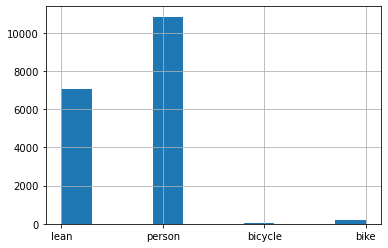

In [19]:
df_TongYoung['cname'].hist()

In [20]:
df_img = df_TongYoung
df_img.shape

(18117, 8)

### Aeroscapes

In [21]:
class_aeroscapes = ['bg', 'person', 'bike', 'car', 'drone', 'boat', 'animal', 'obstacle', 'construction', 'vegetation', 'road', 'sky']
seg_k = len(class_aeroscapes)
seg_k
len(class_aeroscapes)

12

In [22]:
folder_aeroscapes = '/home/mvlab/Downloads/dataset/aeroscapes/'
folder_aeroscapes_rgb = folder_aeroscapes + 'JPEGImages/'
folder_aeroscapes_seg = folder_aeroscapes + 'SegmentationClass/'

os.path.isdir(folder_aeroscapes), os.path.isdir(folder_aeroscapes_rgb), os.path.isdir(folder_aeroscapes_seg)

(True, True, True)

In [23]:
paths_aeroscapes_rgb = glob(folder_aeroscapes_rgb + '*.jpg')
paths_aeroscapes_seg = glob(folder_aeroscapes_seg + '*.png')

paths_aeroscapes_rgb = np.sort(paths_aeroscapes_rgb)
paths_aeroscapes_seg = np.sort(paths_aeroscapes_seg)

len(paths_aeroscapes_rgb), len(paths_aeroscapes_seg)

(3269, 3269)

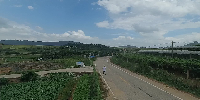

In [24]:
sample_img = Image.open(paths_aeroscapes_rgb[0])
sample_img.resize((200, 100), Image.NEAREST)
                        

sample_seg 0 11 [ 0  1  3  7  8  9 10 11]


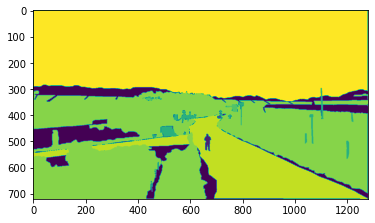

In [25]:
sample_seg = np.array(Image.open(paths_aeroscapes_seg[0]))
print('sample_seg', np.min(sample_seg), np.max(sample_seg), np.unique(sample_seg))
plt.imshow(sample_seg)

In [26]:
sample_rgbs = np.concatenate((np.array(sample_img), np.expand_dims(np.array(sample_seg), -1)), -1)
sample_rgbs.shape

(720, 1280, 4)

type <class 'numpy.ndarray'> uint8 240


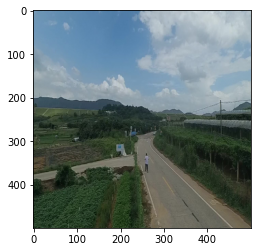

In [27]:
resized_img = np.array(tf.image.resize(sample_rgbs, (500, 500)), np.uint8)
print('type', type(resized_img), resized_img.dtype, np.max(resized_img))
plt.imshow(resized_img[:, :, :3])

In [28]:
def load_Aeroscapes(folder_aeroscapes, stride=1):
    input_list, bbox_list, segment_list, path_list = [], [], [], []
    
    folder_aeroscapes_rgb = folder_aeroscapes + 'JPEGImages/'
    folder_aeroscapes_seg = folder_aeroscapes + 'SegmentationClass/'
    
    if not (os.path.isdir(folder_aeroscapes) and os.path.isdir(folder_aeroscapes_rgb) and folder_aeroscapes_seg):        
        print('not exist Aeroscapes folder', folder_aeroscapes)
        return 
            
    paths_aeroscapes_rgb = glob(folder_aeroscapes_rgb + '*.jpg')
    paths_aeroscapes_seg = glob(folder_aeroscapes_seg + '*.png')

    paths_aeroscapes_rgb = np.sort(paths_aeroscapes_rgb)
    paths_aeroscapes_seg = np.sort(paths_aeroscapes_seg)
    
    print('len images', len(paths_aeroscapes_rgb), len(paths_aeroscapes_seg))
    
    resize_h, resize_w = padded_image_shape
    for i in range(0, len(paths_aeroscapes_rgb), stride):        
        img_rgb = Image.open(paths_aeroscapes_rgb[i])
        img_seg = Image.open(paths_aeroscapes_seg[i])
        img_rgb_resized = img_rgb.resize((resize_w, resize_h))
        img_seg_resized = img_seg.resize((resize_w, resize_h), Image.NEAREST)
        dummy_box = np.array([[0, 0, 200, 200, 0, 0, 0, 0]])
        #np.stack((x0, y0, x0 + w, y0 + h, cls, zero, zero, zero), axis=1)
        input_list.append(np.array(img_rgb_resized))
        bbox_list.append(dummy_box)
        segment_list.append(np.array(img_seg_resized))
        path_list.append(paths_aeroscapes_rgb)
    
    print('len', len(input_list), len(bbox_list), len(segment_list), len(path_list))
    return input_list, bbox_list, segment_list, path_list

input_list_aero, bbox_list_aero, segment_list_aero, path_list_aero = load_Aeroscapes(folder_aeroscapes, stride=1000)

len images 3269 3269
len 4 4 4 4


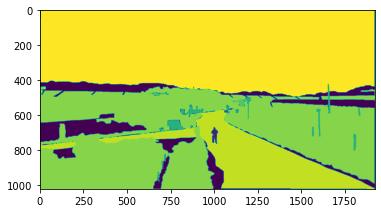

In [29]:
plt.imshow(segment_list_aero[0])

### P-DESTRE load

In [30]:
PDESTRE_columns = ['frame', 'ID', 'x', 'y', 'w', 'h', 'head', 'yaw', 'pitch', 'roll',          
          'gender', 'age', 'height', 'body volume', 'ethnicity', 'hair color', 'hairstyle', 'beard', 'mustache', 'glasses', 
           'head accessories', 'upper cloth', 'lower cloth', 'feet', 'accessories', 'action']
len(PDESTRE_columns)

26

In [31]:
glob(forder_P_DESTRE + '*')

['/home/mvlab/Downloads/dataset/P-DESTRE/annotation',
 '/home/mvlab/Downloads/dataset/P-DESTRE/videos']

In [32]:
#glob(forder_P_DESTRE + 'annotation/*.txt')

In [33]:
def get_dataframe(forder_P_DESTRE):
    list_df = []
    
    list_annotation_path = glob(forder_P_DESTRE + 'annotation/*.txt')
    for i in range(len(list_annotation_path)):
        path_anno = list_annotation_path[i]
        anno_file_name = path_anno.split(os.sep)[-1]
        anno_file_name = anno_file_name[:-4]
        df = pd.read_csv(path_anno, header=None, names=PDESTRE_columns)
        df['video'] = anno_file_name
        list_df.append(df)
        #print(i, anno_file_name, df.shape)
    
    df_all = pd.concat(list_df, axis=0)
    df_all = df_all.reset_index()
    return df_all 

df_P_DESTRE = get_dataframe(forder_P_DESTRE)    
df_P_DESTRE.shape

(1477385, 28)

In [34]:
df_P_DESTRE.columns

Index(['index', 'frame', 'ID', 'x', 'y', 'w', 'h', 'head', 'yaw', 'pitch',
       'roll', 'gender', 'age', 'height', 'body volume', 'ethnicity',
       'hair color', 'hairstyle', 'beard', 'mustache', 'glasses',
       'head accessories', 'upper cloth', 'lower cloth', 'feet', 'accessories',
       'action', 'video'],
      dtype='object')

In [35]:
df_P_DESTRE.iloc[:, 11:-2].nunique()

gender               3
age                  8
height               4
body volume          3
ethnicity            4
hair color           6
hairstyle            6
beard                3
mustache             3
glasses              4
head accessories     4
upper cloth         10
lower cloth          7
feet                 6
accessories          6
dtype: int64

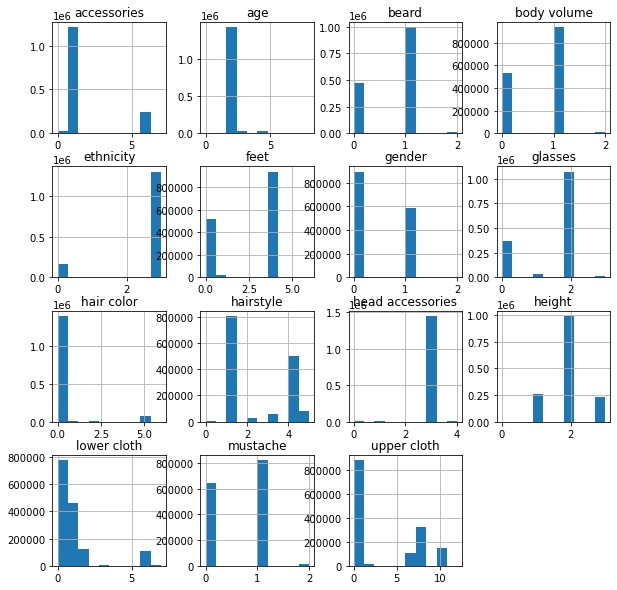

In [36]:
ax = df_P_DESTRE.iloc[:, 11:-2].hist(figsize=(10,10))

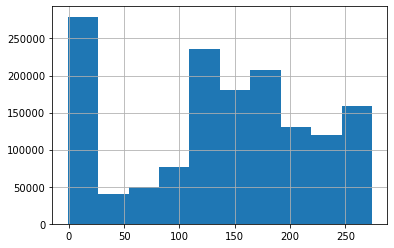

In [37]:
df_P_DESTRE['ID'].hist() #2:unknown

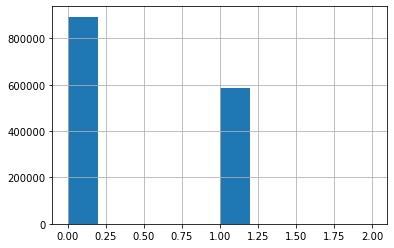

In [38]:
df_P_DESTRE['gender'].hist() #2:unknown

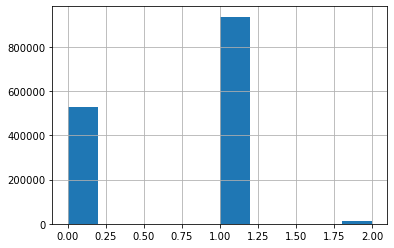

In [39]:
df_P_DESTRE['body volume'].hist()

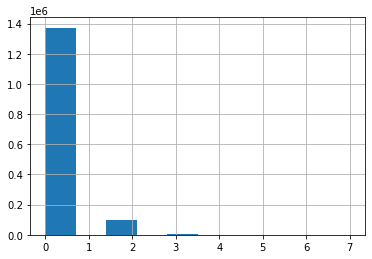

In [40]:
df_P_DESTRE['action'].hist()

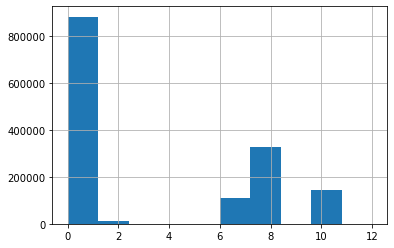

In [41]:
df_P_DESTRE['upper cloth'].hist()

In [42]:
df_P_DESTRE['gender_'] = df_P_DESTRE['gender'].max() - df_P_DESTRE['gender']

In [43]:
df_P_DESTRE['body volume_'] = df_P_DESTRE['body volume'].max() - df_P_DESTRE['body volume']

In [44]:
df_P_DESTRE['upper cloth_'] = df_P_DESTRE['upper cloth'].max() - df_P_DESTRE['upper cloth']
df_P_DESTRE['upper cloth'].max()

12

In [45]:
gender_k = 2
body_volumn_k = 3
upper_cloth_k = 12
label_attribute_k = 8

In [46]:
df_P_DESTRE['ID'].max(), df_P_DESTRE['ID'].nunique()

(274, 262)

In [47]:
#num_classes_real = df_P_DESTRE['ID'].max() + 2

In [48]:
str.format('%#05d' % 11)

'00011'

In [49]:
file_names = []
for fr in df_P_DESTRE['frame'].values:
    file_names.append(str.format('%#05d.jpg' % fr))
    
df_P_DESTRE['file_name'] = file_names
df_P_DESTRE['path'] = forder_P_DESTRE + 'videos/' + df_P_DESTRE['video'] + os.sep + df_P_DESTRE['file_name']

In [50]:
df_P_DESTRE.head(5)

index  frame  ID       x       y       w       h  head     yaw  pitch  ...  \
0      0      1  35  2593.3  1094.3  143.78  386.91     1 -46.228 -12.39  ...   
1      1      1  25  2060.2  1052.2  108.69  342.89     1 -46.228 -12.39  ...   
2      2      1  36  1897.5  1077.2  126.69  331.07     1 -46.228 -12.39  ...   
3      3      1  28  2733.7  1086.1  104.15  315.39     1 -46.228 -12.39  ...   
4      4      1  37  2540.7  1080.6   91.90  338.05     1 -46.228 -12.39  ...   

   lower cloth  feet  accessories  action           video  gender_  \
0            0     0            1       2  18-07-2019-1-1        2   
1            0     0            1       2  18-07-2019-1-1        2   
2            0     0            1       2  18-07-2019-1-1        2   
3            0     0            1       2  18-07-2019-1-1        2   
4            0     0            1       2  18-07-2019-1-1        2   

   body volume_  upper cloth_  file_name  \
0             1             2  00001.jpg   
1             1            12  00001.jpg   
2             1            12  00001.jpg   
3             1            12  00001.jpg   
4             1            12  00001.jpg   

                                                path  
0  /home/mvlab/Downloads/dataset/P-DESTRE/videos/...  
1  /home/mvlab/Downloads/dataset/P-DESTRE/videos/...  
2  /home/mvlab/Downloads/dataset/P-DESTRE/videos/...  
3  /home/mvlab/Downloads/dataset/P-DESTRE/videos/...  
4  /home/mvlab/Downloads/dataset/P-DESTRE/videos/...  

[5 rows x 33 columns]

In [51]:
#remove not exist file
is_exist_file = []
for path_pdestre in df_P_DESTRE['path']:
    is_exist_file.append(os.path.isfile(path_pdestre))

np.mean(is_exist_file)


0.027727369642984057

In [52]:
df_P_DESTRE_exist = df_P_DESTRE[is_exist_file]
df_P_DESTRE_exist.shape

(40964, 33)

In [53]:
df_P_DESTRE_cut = df_P_DESTRE_exist[
    ['ID', 'ID', 'x', 'y', 'w', 'h', 'path','gender_','body volume_','upper cloth_']]
df_P_DESTRE_cut.columns = [
    'cname', 'id', 'x0', 'y0', 'w', 'h', 'path','gender_','body volume_','upper cloth_']

In [54]:
df_P_DESTRE_cut

cname   id      x0       y0       w       h  \
1618        25   25  2200.2  2042.80  110.42  118.37   
1619        38   38  2028.9   761.69   86.19  270.58   
1620        30   30  1804.4  1283.60  125.83  466.63   
1621        13   13  2111.7   757.48   69.43  254.57   
1622        -1   -1  2011.8  1380.10  162.78  476.97   
...        ...  ...     ...      ...     ...     ...   
1477190     -1   -1  2500.8  1276.40  135.73  385.91   
1477191     -1   -1  3499.4  1034.10  100.55  152.40   
1477192     -1   -1  2830.9  1202.50  105.56  276.40   
1477193     -1   -1  2711.3  1171.20  105.94  320.12   
1477194    151  151  2729.9  1150.10   73.46  114.48   

                                                      path  gender_  \
1618     /home/mvlab/Downloads/dataset/P-DESTRE/videos/...        2   
1619     /home/mvlab/Downloads/dataset/P-DESTRE/videos/...        2   
1620     /home/mvlab/Downloads/dataset/P-DESTRE/videos/...        2   
1621     /home/mvlab/Downloads/dataset/P-DESTRE/videos/...        2   
1622     /home/mvlab/Downloads/dataset/P-DESTRE/videos/...        2   
...                                                    ...      ...   
1477190  /home/mvlab/Downloads/dataset/P-DESTRE/videos/...        1   
1477191  /home/mvlab/Downloads/dataset/P-DESTRE/videos/...        2   
1477192  /home/mvlab/Downloads/dataset/P-DESTRE/videos/...        1   
1477193  /home/mvlab/Downloads/dataset/P-DESTRE/videos/...        1   
1477194  /home/mvlab/Downloads/dataset/P-DESTRE/videos/...        2   

         body volume_  upper cloth_  
1618                1            12  
1619                1            12  
1620                1            12  
1621                2             4  
1622                1            12  
...               ...           ...  
1477190             2            11  
1477191             2            12  
1477192             2            11  
1477193             1             6  
1477194             2             4  

[40964 rows x 10 columns]

In [55]:
cond = df_P_DESTRE_cut['id']==-1
cond.sum(), len(cond)

(5480, 40964)

In [56]:
df_P_DESTRE_cut['id'][cond] = 1

<ipython-input-56-25745db2f8fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P_DESTRE_cut['id'][cond] = 1
/home/mvlab/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [57]:
df_img.shape, df_P_DESTRE_cut.shape

((18117, 8), (40964, 10))

In [58]:
df_img.columns, df_P_DESTRE_cut.columns

(Index(['fn', 'cname', 'id', 'x0', 'y0', 'w', 'h', 'path'], dtype='object'),
 Index(['cname', 'id', 'x0', 'y0', 'w', 'h', 'path', 'gender_', 'body volume_',
        'upper cloth_'],
       dtype='object'))

In [59]:
df_img['id'].unique()

array([-1,  0])

In [60]:
df = df_img.drop(columns='fn')
df['id']= 1 #finetune
df['gender_'] = 0
df['body volume_'] = 0
df['upper cloth_'] = 0
df.shape

(18117, 10)

In [61]:
df.isna().sum().sum(), df['path'].nunique()

(0, 11750)

In [62]:
df = df.dropna()
df.shape

(18117, 10)

In [63]:
df['path'].nunique()

11750

In [64]:
class_names, class_names.index('person')

(['bg', 'person', 'bicycle', 'lean', 'car'], 1)

In [65]:
def parsing_annotation(df, is_PEDESTRE=False):
    annotation = dict()
    for i in range(len(df)):
      
        row = df.iloc[i].values
        cname, iden, x0, y0, w, h, path, gender, body_volume, upper_cloth = row
        x1 = x0 + w
        y1 = y0 + h
        if i%10000==0:
            print(i, row)
            
        cls = 1
        if cname=='bike':
            cname = 'bicycle'
        if cname in class_names:            
            cls = class_names.index(cname)
        
        if is_PEDESTRE:
            cls = iden # land 
            cls = iden * 0 + 1
            
        bbox = np.array([x0, y0, x1, y1, cls, gender, body_volume, upper_cloth]).reshape((1, -1))        

        path_image = path#finetune
        if not os.path.isfile(path_image):
            print('not exist', path_image)
            continue
            
        if path_image in annotation.keys():
            pre_bbox = annotation[path_image]
            new_bbox = np.concatenate((pre_bbox, bbox), axis=0)
            #cls_bbox = np.stack(cls_bbox, 0)#.reshape([-1, 6])
            #annotation[path_image].extend(new_bbox)
            annotation[path_image] = new_bbox
        else:
            annotation[path_image] = bbox        
    return annotation

In [66]:
df.shape, df_P_DESTRE_cut.shape

((18117, 10), (40964, 10))

In [67]:
annotation = parsing_annotation(df)
annotation_PDESTRE = parsing_annotation(df_P_DESTRE_cut, is_PEDESTRE=True)

len(annotation), len(annotation_PDESTRE) #basic:1530

0 ['lean' 1 757 695 100 206
 '/home/mvlab/Downloads/dataset/통영/20210204 IMAGE6/out0014.png' 0 0 0]
10000 ['person' 1 737 341 31 65
 '/home/mvlab/Downloads/dataset/통영/미수_스마트시티_통영대교_도천방향1(Ch 01)_[20201215]162700-[20201215]163530(20201215_16270_/02982.jpg'
 0 0 0]
0 [25 25 2200.2 2042.8 110.42 118.37
 '/home/mvlab/Downloads/dataset/P-DESTRE/videos/18-07-2019-1-1/00150.jpg'
 2 1 12]
10000 [234 234 565.59 845.25 208.75 490.46
 '/home/mvlab/Downloads/dataset/P-DESTRE/videos/12-11-2019-3-3/01071.jpg'
 1 2 6]
20000 [140 140 2448.2 495.42 167.71 424.89
 '/home/mvlab/Downloads/dataset/P-DESTRE/videos/13-11-2019-1-5/00771.jpg'
 2 2 4]
30000 [163 163 1916.2 1451.5 90.07 281.36
 '/home/mvlab/Downloads/dataset/P-DESTRE/videos/12-11-2019-2-1/00622.jpg'
 2 2 12]
40000 [14 14 2213.6 1225.7 124.83 350.28
 '/home/mvlab/Downloads/dataset/P-DESTRE/videos/10-07-2019-1-3/00150.jpg'
 2 1 2]


(11750, 2901)

### VisDrone

In [68]:
visdrone_categories = ['bg','pedestrian', 'person', 'car', 'van', 'bus', 'truck', 'motor', 'bicycle', 'awning-tricycle', 'tricycle','empty_0','empty_1']
path_visDrone = '/home/mvlab/Downloads/dataset/VisDrone2019/VisDrone2019-DET-train/'
path_visDrone_annotation = path_visDrone + 'annotations/'
path_visDrone_image = path_visDrone + 'images/'
os.path.isdir(path_visDrone_annotation), os.path.isdir(path_visDrone_image)


(True, True)

In [69]:
def load_visdrone_data(path_visDrone, max_data_m, pedestrian_only=True):    
    annotation = dict()
    path_visDrone_annotation = path_visDrone + 'annotations/'
    path_visDrone_image = path_visDrone + 'images/'
    os.path.isdir(path_visDrone_annotation), os.path.isdir(path_visDrone_image)
    list_annotation = glob(path_visDrone_annotation+'*.*')
    list_image_path = glob(path_visDrone_image+'*.*')
    
    print('len', len(list_annotation), len(list_image_path), list_annotation[0])
    
    for i in range(len(list_annotation)):
        path_annotation = list_annotation[i]
        
        df = pd.read_csv(path_annotation, header=None)
                
        cls = np.array(df.iloc[:, 5])
        bbox_xywh = np.array(df.iloc[:, :4])        
        
        file_name_annotation = path_annotation.split('/')[-1].split('.')[0]
        file_name_image = path_visDrone_image+file_name_annotation+'.jpg'
        
        if not os.path.isfile(file_name_image):
            print('not exist', file_name_image)
            continue
                
        if pedestrian_only:            
            human_mask = np.logical_and(cls > 0, cls < 3)            
            car_mask = cls > 2.5
            is_human_contain = np.any(human_mask)
            human_count = np.sum(human_mask)
            if not is_human_contain or human_count < 20:#30:651
                continue
            
            cls = np.where(human_mask, 1.0, 0.0)
            cls = np.where(car_mask, 4.0, cls)#new            
            use_mask = np.logical_or(human_mask, car_mask)
            cls = cls[use_mask]
            #print('cls', cls)
            bbox_xywh = bbox_xywh[use_mask]            
                      
        x0 = bbox_xywh[:, 0]
        y0 = bbox_xywh[:, 1]
        w = bbox_xywh[:, 2]
        h = bbox_xywh[:, 3]        
        
        #annotation[file_name_image] = np.stack((x0, y0, x0 + w, y0 + h, cls), axis=1)
        zero = np.zeros_like(w)
        annotation[file_name_image] = np.stack((x0, y0, x0 + w, y0 + h, cls, zero, zero, zero), axis=1)
        
        if len(file_name_image)>max_data_m:
            break
        if i%100==0:
            print(len(list_annotation), i, file_name_annotation, len(file_name_image))
    return annotation

In [70]:
if use_visdrone:
    annotation_visdrone = load_visdrone_data(path_visDrone, max_data_m)
    print(len(annotation_visdrone))

In [71]:
len(annotation), len(annotation_PDESTRE)#, len(annotation_visdrone)

(11750, 2901)

### image load

In [72]:
def crop_bbox_image(image, boxes):
    img_objects = []
    image = np.array(image)
    for box in boxes:        
        box = box.astype(np.int)
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1        
        crop_image_arr = image[y1:y2, x1:x2]
        ch, cw, cc = crop_image_arr.shape
        if ch>1 and cw>1:
            img_objects.append(crop_image_arr)
        else:
            print('crop_bbox_image', x2-x1, y2-y1, 'crop_image_arr.shape', crop_image_arr.shape)
        
    return img_objects
    
    
def attach_crop_image(image, boxes, max_crop=200):
        
    crop_bbox_arr = crop_bbox_image(image, np.array(boxes)[:max_crop])
    bbox_k = len(crop_bbox_arr)
    max_col = 30
    
    if bbox_k > 0:
        img_h, img_w, img_c = image.shape
        object_img_w = img_w//bbox_k        
        resize_h = img_h // 8
        resize_w = img_w // bbox_k  
        resize_w = min(max(resize_w, img_w//max_col), img_w//8)
        
        footer_h = resize_h * (1 + (bbox_k-1)//max_col)
        footer = np.zeros((footer_h, img_w, img_c), np.uint8)
        
        for i in range(min(bbox_k, max_crop)):
            crop_arr = crop_bbox_arr[i]
            crop_img = Image.fromarray(crop_arr)                
            crop_img = crop_img.resize((resize_w, resize_h))
            crop_arr_resized = np.array(crop_img)
            offset_y = (i//max_col) * resize_h
            offset_x = (i%max_col) * resize_w
            footer[offset_y:offset_y+resize_h, offset_x:offset_x+resize_w] = crop_arr_resized

        seperate_line = np.zeros_like(footer[:2])
        image = np.concatenate((image, seperate_line, footer), axis=0)    
    return image    

In [73]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)    
    
    img_h = image.shape[0]
    img_w = image.shape[1]
    
    if image.ndim > 2:
        image = attach_crop_image(image, boxes, max_crop=100)
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    box_min_height = np.min(boxes_height)
    box_max_height = np.max(boxes_height)
    title = str.format('(%dx%d) %d box, width:%d ~ %d, height:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width, box_min_height, box_max_height))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = box        
        w, h = x2 - x1, y2 - y1
        
        color = edgecolors[min(len(edgecolors)-1,int(cls))]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 170:
            #score_txt = class_names[int(cls)]
            score_txt = str(int(cls))
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]            
            bbox = sample_box[:, :4]
            label = sample_box[:, 4]
            
            if img_arr.ndim < 2:
                print('img_arr.ndim < 2')
                continue
            
            h = img_arr.shape[0]
            w = img_arr.shape[1]
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            print(i, np.unique(label))
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

In [74]:
np.array((3)).ndim

0

In [75]:
def load_xy(annotation, rescale=1, stride=1, size_cut=False):
    input_list = []
    bbox_list = []
    path_list = []
    i = 0
    #np.random.rand() #미리 만들어놔
    for path_image in annotation:
        i+=1
        if stride!=1 and np.random.randint(1, 1+stride)%stride!=0:
            continue
            
        cls_bbox = annotation[path_image]                
        bbox = np.array(cls_bbox[:, :4])
        attribute = cls_bbox[:, 4:]

        img = Image.open(path_image)    
        scale = np.array((img.width, img.height, img.width, img.height))
        scale = np.reshape(scale, (1, 4))

        if rescale!=1:
            img = img.resize((img.width//rescale, img.height//rescale))

        img_arr = np.array(img)
        try:
            std_v = np.std(img_arr)
            if std_v < 3:
                print('std_v', std_v)
                continue
        except:
            print('error', path_image)
            continue
        
        box_width = bbox[:, 3] - bbox[:, 1]
        box_height = bbox[:, 3] - bbox[:, 1]
        
        if np.min(box_width) < 1 or np.min(box_height) < 1:
            print('box_size < 1', box_width, box_height)#check
            continue
            
        bbox_norm = bbox.astype(np.float) / scale.astype(np.float)
        cls_bbox_norm = np.concatenate((bbox_norm, attribute), axis=1)

        if size_cut:                
            box_height = cls_bbox_norm[:, 3] - cls_bbox_norm[:, 1]
            box_height_max = np.max(box_height)
            if box_height_max < 0.05 or box_height_max > 0.2:
                continue

        input_list.append(img_arr)
        bbox_list.append(cls_bbox_norm)
        path_list.append(path_image)
        if len(input_list)%100==0:        
            print(len(annotation), i, len(input_list))   
        if len(input_list) > max_data_m:
            break       

    print(len(input_list), len(bbox_list))
    return input_list, bbox_list

In [76]:
print(len(annotation))#6258, 7165, 7467, 7956, 9428, 9889, 10194, 10569, 11603, 11750
input_list, bbox_list = load_xy(annotation, stride=2)
#error /home/mvlab/Downloads/dataset/통영/도천2/01748.png

11750
51 51


In [77]:
len(input_list)

51

(109, 8) 3.0


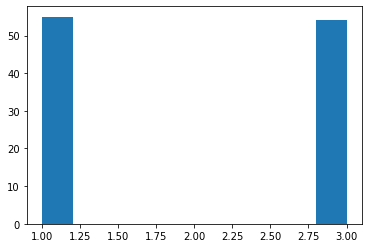

In [78]:
cbbox = np.concatenate(bbox_list, 0)
print(cbbox.shape, np.max(cbbox[:, 4])) # basic:1736 + P-DESTRE > 9757
h = plt.hist(cbbox[:, 4])

0 [3.]


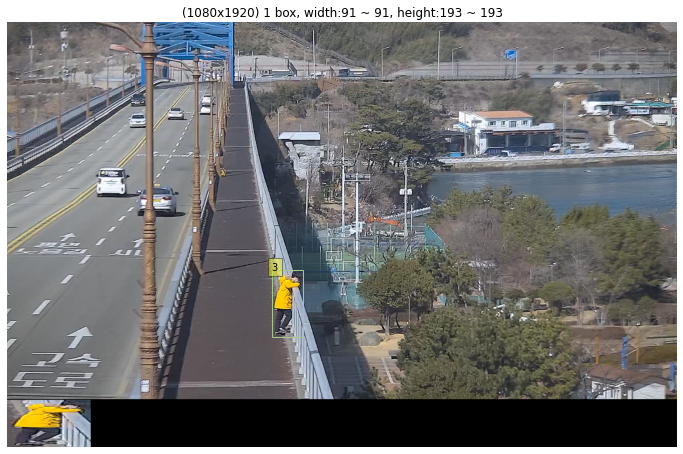

In [79]:
display_data(input_list, bbox_list, stride=1000)

In [80]:
bbox_list[0]

array([[0.39479167, 0.65648148, 0.4421875 , 0.83518519, 3.        ,
        0.        , 0.        , 0.        ]])

In [81]:
if use_pedestrian:
    input_list_PDESTRE, bbox_list_PDESTRE = load_xy(annotation_PDESTRE, rescale=4, stride=6)

In [82]:
if use_visdrone:
    list_visdrone_x, list_visdrone_y = load_xy(annotation_visdrone, size_cut=True)

In [83]:
if use_visdrone:
    cbbox = np.concatenate(list_visdrone_y, 0)
    print(cbbox.shape, np.max(cbbox[:, 4])) # basic:1736 + P-DESTRE > 9757
    h = plt.hist(cbbox[:, 4])

In [84]:
len(input_list)#, len(input_list_PDESTRE)#, len(list_visdrone_x)

51

list_visdrone_x, list_visdrone_y = load_visdrone_data(path_visDrone)
print(len(list_visdrone_x))

In [85]:
#max_data_m, np.unique(np.concatenate(list_visdrone_y, 0)[:, -1])

display_data(list_visdrone_x, list_visdrone_y, stride=100)

(109, 8) 3.0


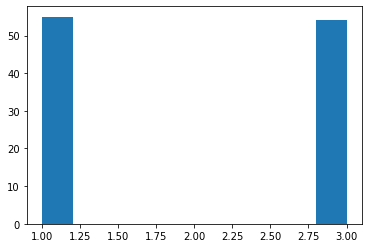

In [86]:
cbbox = np.concatenate(bbox_list, 0)
print(cbbox.shape, np.max(cbbox[:, 4])) # basic:1736 + P-DESTRE > 9757
h = plt.hist(cbbox[:, 4])

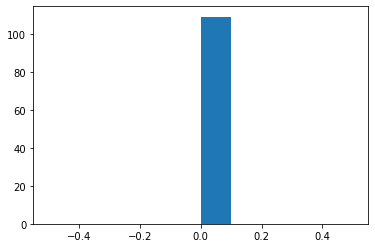

In [87]:
h = plt.hist(cbbox[:, -1])

In [88]:
cbbox = np.concatenate(bbox_list, 0)

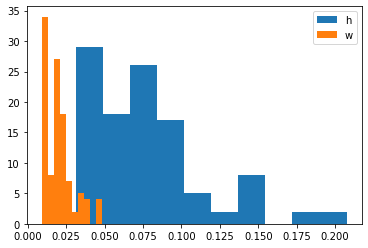

In [89]:
box_w = cbbox[:, 2] - cbbox[:, 0]
box_h = cbbox[:, 3] - cbbox[:, 1]
h = plt.hist(box_h, label='h')
h = plt.hist(box_w, label='w')
plt.legend()

In [90]:
np.corrcoef(box_w, box_h)

array([[1.        , 0.95874977],
       [0.95874977, 1.        ]])

In [91]:
cbbox.shape, 1/9

((109, 8), 0.1111111111111111)

In [92]:
a = np.array([1,2,3])

In [93]:
np.where(a<2, 10, a)

array([10,  2,  3])

In [94]:
def tile_object_biggest_center(X, BBOX, scope=0.5, min_cls=1):
    
    crop_xs = []
    crop_bboxs = []
    for i in range(len(X)):
        x = X[i]
        img_h, img_w, img_c = x.shape
        bbox = BBOX[i].copy()
        #print('len', len(x), len(bbox), x.shape, bbox.shape)
        
        x0 = bbox[:, 0]
        x1 = bbox[:, 2]
        cls = bbox[:, 4]
        
        if not np.any(cls - 0.1 > min_cls):
            continue            
    
        box_size = (bbox[:, 2] - bbox[:, 0]) * (bbox[:, 3] - bbox[:, 1])
        box_max_index = np.argmax(box_size)
        if np.max(cls) > 1:
            box_max_index = np.argmax(cls)
            
        #print('box_max_index', box_max_index)
        box_center = bbox[box_max_index]
        #print('box_center', box_center)
                    
        cx = (box_center[0] + box_center[2])/2        

        if cx < scope:
            tx0 = np.maximum(0, cx - scope/2)
            tx1 = tx0 + scope
        elif cx > 1 - scope:
            tx1 = np.minimum(1.0, cx + scope/2)
            tx0 = tx1 - scope
        else:
            tx0 = cx - scope/2
            tx1 = cx + scope/2
        
        epsilon = 1e-8 
        bbox[:, 0] = np.where(np.logical_and(x0 < tx0, x1 < tx1) , tx0, x0)        
        bbox[:, 2] = np.where(np.logical_and(x1 > tx1, x0 > tx0) , tx1, x1)                
        cond = (bbox[:, 2] - bbox[:, 0]) > epsilon
        
        if not np.any(cond):
            print('no valid center box', bbox)
            continue
            
        bbox = bbox[cond]
        cls = bbox[:, 4]
        attributes = bbox[:, 4:]
        
        x0 = bbox[:, 0]
        y0 = bbox[:, 1]
        x1 = bbox[:, 2]
        y1 = bbox[:, 3]
        tbox = np.stack(((x0 - tx0)/scope, y0, (x1 - tx0)/scope, y1), axis=1)            
        tbox = np.concatenate((tbox, attributes), -1)

        img_x0 = int(tx0 * img_w)
        img_x1 = img_x0 + int(img_w*scope)
        timg = x[:, img_x0:img_x1]

        img = Image.fromarray(timg)
        dst_w = int(padded_image_shape[1]*scope)
        img_resized = img.resize((dst_w, padded_image_shape[0]))
        arr_resized = np.array(img_resized)            

        crop_xs.append(arr_resized)
        crop_bboxs.append(tbox)
        
    return crop_xs, crop_bboxs

In [95]:
def attach_tiled_data(X, Y, col=2, row = 1):
    
    m = len(X)
    use_m = (m // (row * col)) * (row * col)    
    print('use_m', use_m)
    X = np.array(X[:use_m])
    Y = np.array(Y[:use_m])
    
    x_split = np.split(X, col, axis=0)
    y_split = np.split(Y, col, axis=0)
        
    print('y_split', X[0].shape,  x_split[0].shape, x_split[1].shape, y_split[0].shape, y_split[1].shape)
        
    stride_i = len(x_split[0])
    scale_x = 1.0 / col
    
    list_Y = []    
    for i in range(stride_i):
        list_y = []
                
        for j in range(col):
            y = Y[i + stride_i * j]
            y_box = y[:, :4]
            y_attr = y[:, 4:]
            x0, y0, x1, y1 = np.split(y_box, 4, -1) 
            
            x0 = x0 * scale_x + j * scale_x
            x1 = x1 * scale_x + j * scale_x

            y_box = np.concatenate((x0, y0, x1, y1), -1)
            new_y = np.concatenate((y_box, y_attr), axis=-1)
            
            list_y.append(new_y)
        
        list_Y.append(np.concatenate(list_y, axis=0))
       
    
    x_concat = np.concatenate(x_split, axis=2)
    
    print('x_concat', x_concat.shape, 'type y',type(y_split))
        
    return list(x_concat), list_Y

In [96]:
def attach_tiled_data_row(X, Y, row=2):
    
    m = len(X)
    use_m = (m // row) * row    
    print('use_m', use_m)
    X = np.array(X[:use_m])
    Y = np.array(Y[:use_m])
    
    x_split = np.split(X, row, axis=0)
    y_split = np.split(Y, row, axis=0)
    
    print('len()', len(x_split), len(y_split), len(x_split[0]))
    print('y_split', x_split[0].shape, x_split[1].shape, y_split[0].shape, y_split[1].shape)
        
    stride_i = len(x_split[0])
    scale_y = 1.0 / row
    
    list_Y = []    
    for i in range(stride_i):
        list_y = []
                
        for j in range(row):
            y = Y[i + stride_i * j]
            y_box = y[:, :4]
            y_attr = y[:, 4:]
            x0, y0, x1, y1 = np.split(y_box, 4, -1) 
            
            y0 = y0 * scale_y + j * scale_y
            y1 = y1 * scale_y + j * scale_y

            y_box = np.concatenate((x0, y0, x1, y1), -1)
            new_y = np.concatenate((y_box, y_attr), axis=-1)
            
            list_y.append(new_y)
        
        list_Y.append(np.concatenate(list_y, axis=0))
       
    
    x_concat = np.concatenate(x_split, axis=1)
    
    print('x_concat', x_concat.shape, 'type y',type(y_split))
        
    return list(x_concat), list_Y

In [97]:
def get_bg_paths():
    list_bg_jpg = glob(folder_water_bg + '*')
    list_bg_jpg0 = glob(folder_water_bg[:-1] + '0/*')
    print(len(list_bg_jpg), len(list_bg_jpg0))
    return list_bg_jpg0[1::2]#+ list_bg_jpg

In [98]:
def box_convert_cxy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate(( (y0+y1)/2, (x0+x1)/2 ), axis=1)

def box_swap_xy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate((x0, y0, x1, y1), axis=1)

def box_convert_to_xywh(boxes):
    return np.concatenate(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]], axis=-1,)

def box_convert_to_corners(boxes):    
    return np.concatenate(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0], axis=-1,)

def angle_to_radian(angle):
    return angle * np.pi/180

def rotate_images(X, angle):
    rotate_X = []
    for i in range(len(X)):        
        x = X[i]
        img_h = x.shape[0]
        img_w = x.shape[1]
        img = Image.fromarray(x)                
        img_rotated = img.rotate(angle)
        rotate_X.append(np.array(img_rotated))

    return rotate_X
    
def gen_rotate_data(X, BBOX, angle):
    rotate_xs = []
    rotate_bboxs = []
    m = len(X)
    for i in range(m):        
        x = X[i]
        
        bbox = BBOX[i]       
        attributes = bbox[:, 4:]        
        box = bbox[:, :4]
        box_xywh = box_convert_to_xywh(box)
        box_xy = box_xywh[:, :2] 
        box_wh = box_xywh[:, 2:] 
        box_uv = (np.reshape(box_xy, [-1, 2]) - 0.5) * 2
        
        img_h, img_w, img_c = x.shape
        img = Image.fromarray(x)        
        scale_mat = np.array([1, 0, 0, 1.0*img_h/img_w]).reshape((2,2))
        scale_mat_rev = np.array([1, 0, 0, 1.0*img_w/img_h]).reshape((2,2))
        
        if np.random.rand() > 0.5:
            angle = -angle
        radian = angle_to_radian(angle)        
        rotate_mat = np.array([np.cos(radian), -np.sin(radian), np.sin(radian), np.cos(radian)])        
        rotate_mat = np.reshape(rotate_mat, (2, 2))
        box_uv_trans = np.matmul(box_uv, scale_mat)
        box_uv_trans = np.matmul(box_uv_trans, rotate_mat)
        box_uv_trans = np.matmul(box_uv_trans, scale_mat_rev)
        box_trans = (box_uv_trans + 1)/2
        box_trans_xy = np.reshape(box_trans, [-1, 2])
        box_trans_xywh = np.concatenate((box_trans_xy, box_wh), axis=1)
        box_trans = box_convert_to_corners(box_trans_xywh)
   
        #if np.min(box_trans)<0 or np.max(box_trans)>1: continue               
        
        bbox_trans = np.concatenate((box_trans, attributes), -1)
   
        img_rotated = img.rotate(angle)
        #plt.imshow(img_rotated)
        rotate_xs.append(np.array(img_rotated))
        rotate_bboxs.append(bbox_trans)

    return rotate_xs, rotate_bboxs        

display_data(input_list, bbox_list, stride=100)

In [99]:
m = len(input_list)
print('m', m)
s = 1
input_list_train = input_list[::s]
input_list_test = input_list[1::2]
bbox_list_train = bbox_list[::s]
bbox_list_test = bbox_list[1::2]
print('bbox_list_train', len(bbox_list), len(bbox_list_train), len(bbox_list_test))

m 51
bbox_list_train 51 51 25


In [100]:
len(input_list_train)

51

In [101]:
attach_col = 7

In [102]:
s = 1
crop_xs, crop_bboxs = tile_object_biggest_center(input_list_train[::s], bbox_list_train[::s], scope=1/attach_col, min_cls=0)
print('crop_xs', len(crop_xs), len(crop_bboxs), crop_xs[0].shape, crop_bboxs[0])
#display_data(crop_xs, crop_bboxs, stride=100)

crop_xs 51 51 (1024, 274, 3) [[0.33411458 0.65648148 0.66588542 0.83518519 3.         0.
  0.         0.        ]]


In [103]:
for box in crop_bboxs:
    w = box[:, 2] - box[:, 0]
    w_min = np.min(w)
    if w_min < 0.01:
        print(w_min)

In [104]:
is_important_class_resample = False
is_rotate_attach = False

In [105]:
if is_important_class_resample:    
    crop_xs_i, crop_bboxs_i = tile_object_biggest_center(input_list_train[::s], bbox_list_train[::s], scope=1/attach_col, min_cls=2)
    print('crop_xs_i', len(crop_xs_i), len(crop_bboxs_i))
    rotate_xs_i0, rotate_bboxs_i0 = gen_rotate_data(crop_xs_i, crop_bboxs_i, angle=0.5)
    
    print('rotate_xs', len(rotate_xs_i0), len(rotate_bboxs_i0))
    crop_xs.extend(rotate_xs_i0)
    crop_bboxs.extend(rotate_bboxs_i0)    
    print(len(crop_xs))

In [106]:
len(crop_xs)

51

In [107]:
if is_rotate_attach:
    rotate_xs, rotate_bboxs = gen_rotate_data(crop_xs, crop_bboxs, angle=0.5)    
    rotate_xs.extend(crop_xs)
    rotate_bboxs.extend(crop_bboxs)

    print('rotate_xs', len(rotate_xs), len(rotate_bboxs))
    print('crop_xs', len(crop_xs), len(rotate_xs))
else:
    rotate_xs = crop_xs
    rotate_bboxs = crop_bboxs

In [108]:
def apply_permutation(lst, p):
    return [lst[x] for x in p]

In [109]:
rotate_ind = np.arange(len(rotate_bboxs))
np.random.shuffle(rotate_ind)

In [110]:
rotate_xs = apply_permutation(rotate_xs, rotate_ind)
rotate_bboxs = apply_permutation(rotate_bboxs, rotate_ind)

In [111]:
attach_x, attach_bbox = attach_tiled_data(rotate_xs, rotate_bboxs, col=attach_col)
len(attach_x), len(attach_bbox)

use_m 49
y_split (1024, 274, 3) (7, 1024, 274, 3) (7, 1024, 274, 3) (7,) (7,)
x_concat (7, 1024, 1918, 3) type y <class 'list'>


(7, 7)

0 [1. 3.]


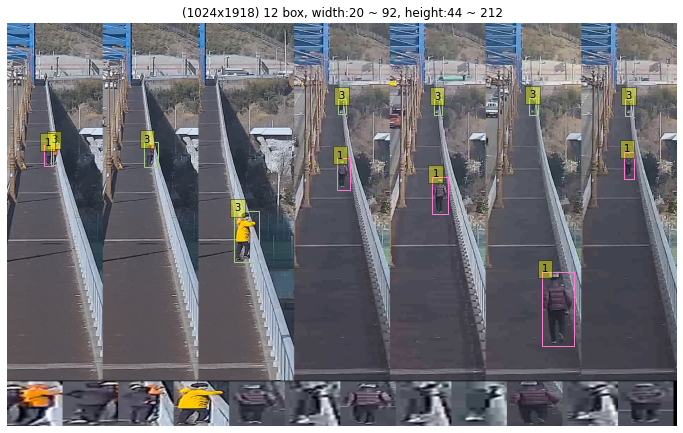

In [112]:
display_data(attach_x, attach_bbox, stride=100)

insert_stride = len(input_list_train)//len(attach_x)

for i in range(len(attach_x)):
    input_list_train.insert(i*insert_stride, attach_x.pop())
    bbox_list_train.insert(i*insert_stride, attach_bbox.pop())
    
print('bbox_list_train', len(input_list_train), len(bbox_list_train), len(bbox_list_test))

input_list_train.extend(rotate_xs)
bbox_list_train.extend(rotate_bboxs)
len(input_list_train), len(rotate_xs)

attach_x, attach_bbox = attach_tiled_data(rotate_xs, rotate_bboxs, row=1, col=2)
len(attach_x), len(attach_bbox)

In [113]:
if use_pedestrian:
    display_data(input_list_PDESTRE, bbox_list_PDESTRE, stride=100)

display_data(list_visdrone_x, list_visdrone_y, stride=100)

In [114]:
if use_pedestrian:    
    print(len(input_list_PDESTRE), len(bbox_list_PDESTRE), input_list_PDESTRE[0].shape)

rotate_xs.extend(crop_xs)
rotate_bboxs.extend(crop_bboxs)

In [115]:
if use_pedestrian:    
    m = len(input_list_PDESTRE)
    for i in range(m):
        x = input_list_PDESTRE[i]
        y = bbox_list_PDESTRE[i]
        if not x.shape==(540, 960, 3):
            print(i, x.shape)
            if x.shape[1]<500:
                print(x.shape)
                input_list_PDESTRE.pop(i)
                bbox_list_PDESTRE.pop(i)
        m = len(input_list_PDESTRE)

In [116]:
print('crop_xs', len(crop_xs), len(rotate_xs))

crop_xs 51 51


In [117]:
if use_pedestrian:
    display_data(input_list_PDESTRE, bbox_list_PDESTRE, stride=1000)

In [118]:
if use_pedestrian:
    attach_xs, attach_bboxs = attach_tiled_data(np.stack(input_list_PDESTRE, 0), bbox_list_PDESTRE, col=2)
    
    print(len(attach_xs), len(attach_bboxs))

In [119]:
if use_pedestrian:
    print(len(attach_xs), len(attach_bboxs))
    display_data(attach_xs, attach_bboxs, stride=1000)

In [120]:
if use_pedestrian:
    attach_x_row, attach_bbox_row = attach_tiled_data_row(attach_xs, attach_bboxs, row=2)  
    print(len(attach_x_row), len(attach_bbox_row))

In [121]:
if use_pedestrian:
    display_data(attach_x_row, attach_bbox_row, stride=100)

In [122]:
if use_pedestrian:
    print('attach_x', len(attach_x), 'attach_x_row', len(attach_x_row))
    attach_x.extend(attach_x_row)
    attach_bbox.extend(attach_bbox_row)
    print('attach_x', len(attach_x))

In [123]:
if use_pedestrian:
    insert_stride = len(attach_x)//len(attach_x_row)

    for i in range(len(attach_x_row)):
        attach_x.insert(i*insert_stride, attach_x_row.pop())
        attach_bbox.insert(i*insert_stride, attach_bbox_row.pop())

    print('bbox_list_train', len(attach_x), len(attach_x_row))

In [124]:
insert_stride = len(input_list_train)//len(attach_x)

for i in range(len(attach_x)):
    input_list_train.insert(i*insert_stride, attach_x.pop())
    bbox_list_train.insert(i*insert_stride, attach_bbox.pop())

print('bbox_list_train', len(input_list_train), len(attach_x))

bbox_list_train 58 0


input_list_train = attach_x
bbox_list_train = attach_bbox

attach_xs.extend(attach_x)
attach_bboxs.extend(attach_bbox)

len(attach_xs), len(attach_bboxs)

display_data(attach_xs, attach_bboxs, stride=100)

input_list_train.extend(attach_xs)
bbox_list_train.extend(attach_bboxs)

In [125]:
if use_visdrone:
    display_data(list_visdrone_x, list_visdrone_y, stride=100)

In [126]:
if use_visdrone:
    
    insert_stride = len(input_list_train)//len(list_visdrone_x)
    print('insert_stride', insert_stride)

    for i in range(len(list_visdrone_x)):
        input_list_train.insert(i*insert_stride, list_visdrone_x.pop())
        bbox_list_train.insert(i*insert_stride, list_visdrone_y.pop())

    print('bbox_list_train', len(input_list_train), len(list_visdrone_y))

In [127]:
print('len', len(input_list_train), len(input_list_test))

len 58 25


In [128]:
len(input_list_aero), len(bbox_list_aero), len(segment_list_aero)

(4, 4, 4)

0 [0]


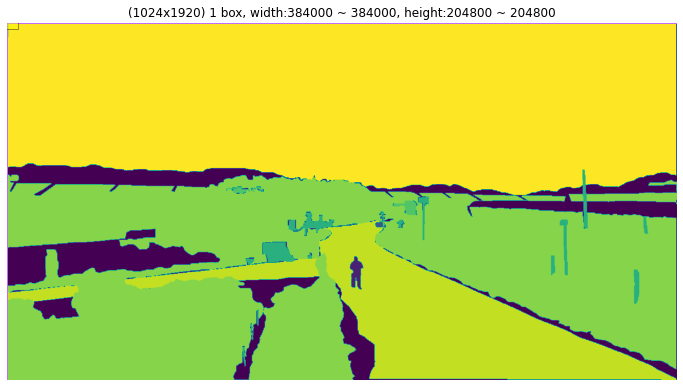

1 [0]


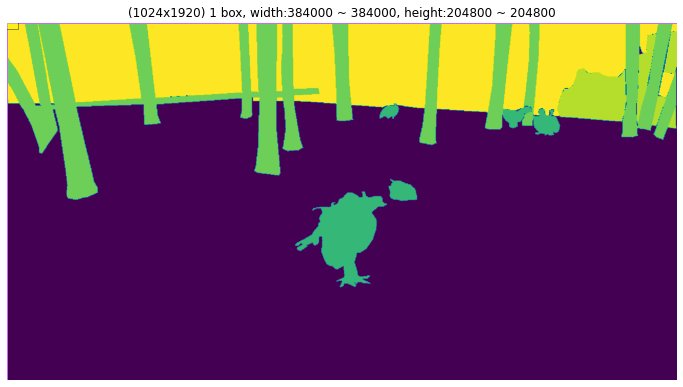

2 [0]


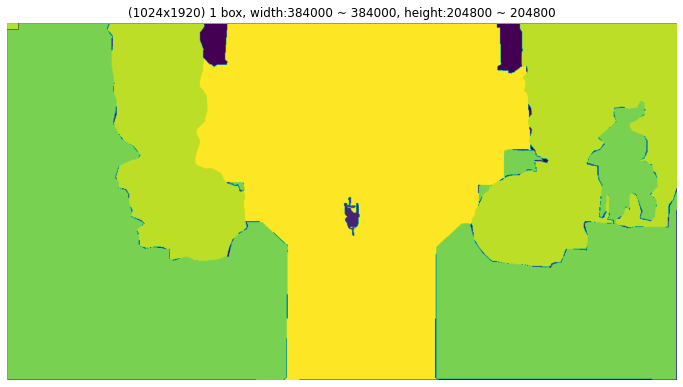

3 [0]


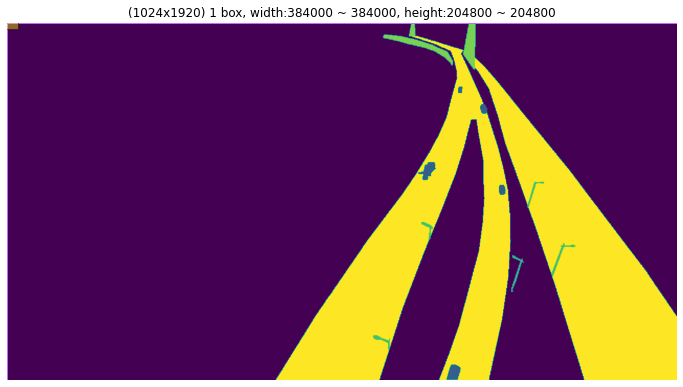

In [129]:
display_data(segment_list_aero, bbox_list_aero, stride=1)

### add segmentation data

In [130]:
seg_list_train = []

insert_stride = len(input_list_train)//len(input_list_aero)
print('insert_stride', insert_stride)

for i in range(len(input_list_train)):
    seg_list_train.append(np.array([0]))
    
for i in range(len(input_list_aero)):
    input_list_train.insert(i*insert_stride, input_list_aero.pop())
    bbox_list_train.insert(i*insert_stride, bbox_list_aero.pop())    
    seg_list_train.insert(i*insert_stride, segment_list_aero.pop())    
    
print('len', len(input_list_train), len(bbox_list_train), len(seg_list_train))

insert_stride 14
len 62 62 62


0 [3.]


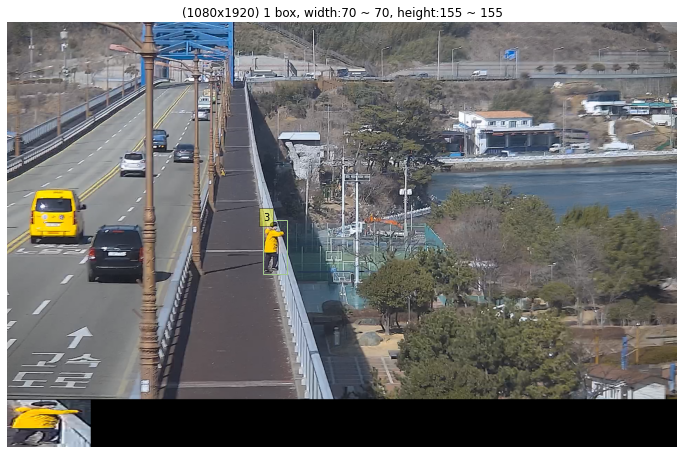

In [131]:
display_data(input_list_test, bbox_list_test, stride=100)

0 [0]


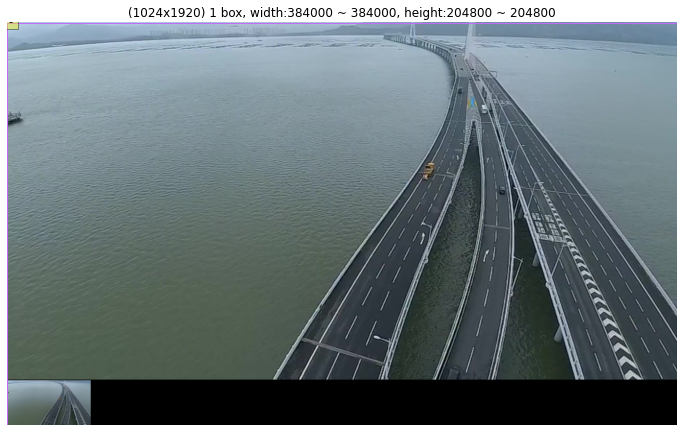

In [132]:
display_data(input_list_train[:], bbox_list_train[:], stride=1001)

0 [0]


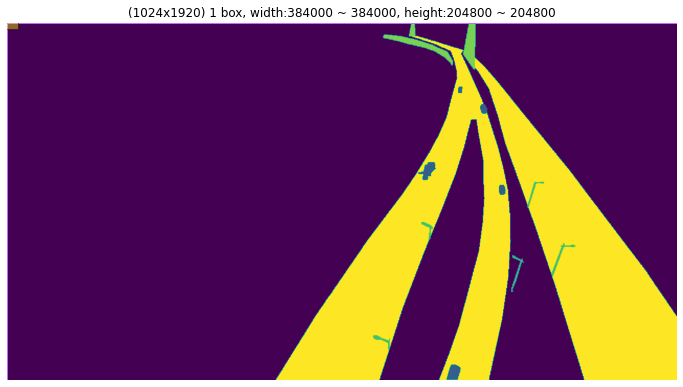

img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
14 [0]


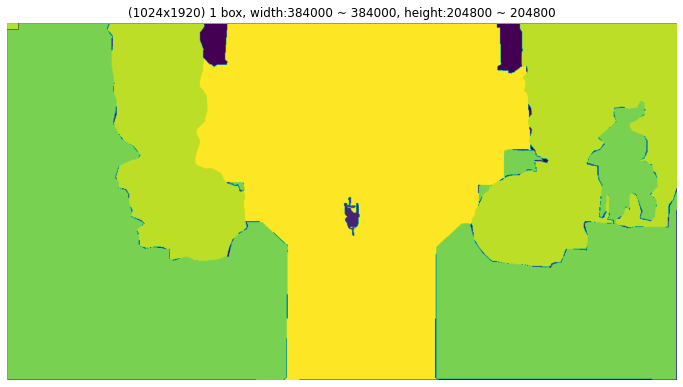

img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
28 [0]


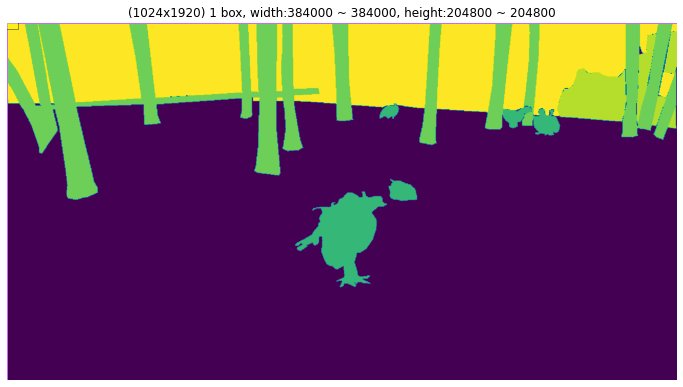

img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
42 [0]


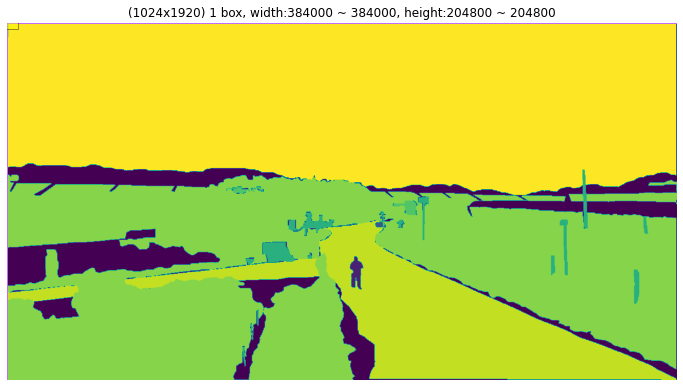

img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2
img_arr.ndim < 2


In [133]:
display_data(seg_list_train, bbox_list_train, stride=1)

In [134]:
def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.
    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.
    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


"""
## Computing pairwise Intersection Over Union (IOU)
As we will see later in the example, we would be assigning ground truth boxes
to anchor boxes based on the extent of overlapping. This will require us to
calculate the Intersection Over Union (IOU) between all the anchor
boxes and ground truth boxes pairs.
"""

def compute_iou(boxes1, boxes2):#compute_iou(anchor_boxes, gt_boxes)
    """Computes pairwise IOU matrix for given two sets of boxes
    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [135]:
level_end - level_start, anchor_k

(3, 6)

In [136]:

"""
## Implementing Anchor generator
Anchor boxes are fixed sized boxes that the model uses to predict the bounding
box for an object. It does this by regressing the offset between the location
of the object's center and the center of an anchor box, and then uses the width
and height of the anchor box to predict a relative scale of the object. In the
case of RetinaNet, each location on a given feature map has nine anchor boxes
(at three scales and three ratios).
"""
class AnchorBox:
    """Generates anchor boxes.
    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.
    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.level_start = level_start
        self.level_end = level_end
        
        if anchor_k==9:
            self.aspect_ratios = [0.5, 1.0, 2.0]        
            self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        elif anchor_k==6:
            self.aspect_ratios = [0.5, 1.0] #area / aspect_ratios. = height
            self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]        
        else:
            self.aspect_ratios = [1.0]#area / ratio = height
            self.scales = [2 ** x for x in [0]]
                
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(self.level_start, self.level_end)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 196.0, 256.0]]                        
        self._areas = self._areas[:level_end - level_start]
        
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level
        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.
        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - self.level_start]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - self.level_start], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return tf.concat(anchors, axis=0)
    
    def get_anchors_check(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return anchors

In [137]:
level_start, level_end

(4, 7)

In [138]:
anchor_check = AnchorBox()

In [139]:
anchors = anchor_check.get_anchors_check(128,128)
for anchor in anchors:
    print(anchor.shape, anchor[-1])

(384, 4) tf.Tensor([120.       120.        50.796833  50.796833], shape=(4,), dtype=float32)
(96, 4) tf.Tensor([112.       112.       101.593666 101.593666], shape=(4,), dtype=float32)
(24, 4) tf.Tensor([ 96.       96.      203.18733 203.18733], shape=(4,), dtype=float32)


In [140]:
padded_image_shape, 128*8

((1024, 1920), 1024)

In [141]:
"""
## Preprocessing data
Preprocessing the images involves two steps:
- Resizing the image: Images are resized such that the shortest size is equal
to 800 px, after resizing if the longest side of the image exceeds 1333 px,
the image is resized such that the longest size is now capped at 1333 px.
- Applying augmentation: Random scale jittering  and random horizontal flipping
are the only augmentations applied to the images.
Along with the images, bounding boxes are rescaled and flipped if required.
"""

def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.
    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1)
   
    return image, boxes


def resize_and_pad_image_seg(
    image, segmap, min_side=1024.0, max_side=11333.0, jitter=[128*8, 128*8+1], stride=128.0):
   
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    
    ratio = min_side / tf.reduce_min(image_shape)
    
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    image = tf.image.pad_to_bounding_box(image, 0, 0, padded_image_shape[0], padded_image_shape[1]) 
    
    segmap_exp = tf.expand_dims(segmap, -1)
    segmap_exp = tf.image.resize(segmap_exp, tf.cast(image_shape, dtype=tf.int32), 'nearest')
    segmap_exp = tf.image.pad_to_bounding_box(segmap_exp, 0, 0, padded_image_shape[0], padded_image_shape[1])        
    segmap = tf.squeeze(segmap_exp, -1)
            
    return image, segmap_exp, image_shape, ratio


def resize_and_pad_image(
    image, min_side=1024.0, max_side=11333.0, jitter=[128*8, 128*8+1], stride=128.0):
   
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    
    ratio = min_side / tf.reduce_min(image_shape)
    
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    image = tf.image.pad_to_bounding_box(image, 0, 0, padded_image_shape[0], padded_image_shape[1]) 
   
    return image, image_shape, ratio


def resize_and_pad_image_bbox(
    image, bbox, mask_obj=None, min_side=1024.0, max_side=1024.0*4, jitter=[128*7+32, 128*8-32], stride=128.0
):
    #image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
    """Resizes and pads image while preserving aspect ratio.
    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.
    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    ratio_jitter = tf.random.uniform(tf.shape(image_shape), -32, 32, dtype=tf.float32)
    image_shape += ratio_jitter      
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    if mask_obj!=None:
        mask_obj = tf.image.resize(mask_obj, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(image, 0, 0, padded_image_shape[0], padded_image_shape[1])
    if mask_obj!=None:
        mask_obj = tf.image.pad_to_bounding_box(mask_obj, 0, 0, padded_image_shape[0], padded_image_shape[1])        
    padded_image_shape = tf.cast(padded_image_shape, tf.float32)              
    pad_ratio = tf.cast(image_shape, tf.float32) / padded_image_shape
    bbox_padded = tf.stack(
        [
            bbox[:, 0] * pad_ratio[1],
            bbox[:, 1] * pad_ratio[0],
            bbox[:, 2] * pad_ratio[1],
            bbox[:, 3] * pad_ratio[0],
        ],
        axis=-1,
    )
    if mask_obj!=None:
        return image, padded_image_shape, ratio, bbox_padded, mask_obj    
    return image, padded_image_shape, ratio, bbox_padded


def unnormalize_box(bbox, image_shape):
    bbox = tf.cast(bbox, tf.float32)
    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)    
    return bbox    


def preprocess_data(image, segmap, cls_bbox):
    """Applies preprocessing step to a single sample
    Arguments:
      sample: A dict representing a single training sample.
    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
     
    bbox = cls_bbox[:, :4]    
    attribute = tf.cast(cls_bbox[:, 4:], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)        
    #image, image_shape, _, bbox = resize_and_pad_image_bbox(image, bbox)    
    
    rgbs = tf.concat((image, tf.expand_dims(segmap, -1)), -1)
    rgbs, image_shape, _ = resize_and_pad_image(rgbs)
    bbox = unnormalize_box(bbox, image_shape)
    
    return rgbs, bbox, attribute

def preprocess_test_data(image, segmap, cls_bbox):         
    bbox = cls_bbox[:, :4]    
    attribute = tf.cast(cls_bbox[:, 4:], dtype=tf.int32)
    rgbs = tf.concat((image, tf.expand_dims(segmap, -1)), -1)
    rgbs, image_shape, _ = resize_and_pad_image(rgbs)
    bbox = unnormalize_box(bbox, image_shape)    
    
    return rgbs, bbox, attribute

In [142]:
use_weather_effect

False

In [143]:
def image_color_augment(x):
    if tf.random.uniform(()) < -0.5:
        x_max = tf.reduce_max(x, [1, 2], True)
        x = x_max - x
    if tf.random.uniform(()) < -0.2:
        r, g, b = tf.split(x, 3, axis=-1)
        x = tf.concat((r, b, g), -1)
    elif tf.random.uniform(()) < -0.2:
        r, g, b = tf.split(x, 3, axis=-1)
        x = tf.concat((b, r, g), -1)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_hue(x, 0.08)
        x = tf.image.random_saturation(x, 0.6, 1.6)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_brightness(x, 0.05)
        x = tf.image.random_contrast(x, 0.7, 1.3)
    if tf.random.uniform(()) < -0.2:
        gray = tf.image.rgb_to_grayscale(x)
        x = tf.concat((gray, gray, gray), -1)        
    if tf.random.uniform(()) < -0.2:
        noise = tf.random.normal(tf.shape(x), stddev=tf.pow(tf.reduce_mean(x), 0.3))
        x += noise
    if tf.random.uniform(()) < 0.2:
        x = gaussian_filter2d(x, filter_shape=tuple(np.random.randint(1, 10, (2))), sigma=10)
        #x = gaussian_filter2d(x, filter_shape=np.random.randint(3, 10, (2)), sigma=10)
    if tf.random.uniform(()) < 0.2:        
        x = sharpness(x, factor=10)
    if tf.random.uniform(()) < 0.2:        
        if use_weather_effect:
            weather_k = len(weather_images)                            
            h = tf.shape(x)[1]
            w = tf.shape(x)[2]
            weather_image = weather_images[np.random.randint(weather_k)]
            weather_image = tf.image.resize(weather_image, tf.cast((h, w), dtype=tf.int32))
            weather_image = tf.expand_dims(weather_image, 0)
            x = (x // 3) * 2 + weather_image//3
            
    #x = tf.image.random_jpeg_quality(x, 0, 1.0)
    #x = tf.clip_by_value(x, 0, 1)
    
    return x

In [144]:
"""
## Encoding labels
The raw labels, consisting of bounding boxes and class ids need to be
transformed into targets for training. This transformation consists of
the following steps:
- Generating anchor boxes for the given image dimensions
- Assigning ground truth boxes to the anchor boxes
- The anchor boxes that are not assigned any objects, are either assigned the
background class or ignored depending on the IOU
- Generating the classification and regression targets using anchor boxes
"""

class LabelEncoder:
    """Transforms the raw labels into targets for training.
    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.
    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )    
    
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target
    
    def _compute_box_width(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_w = matched_gt_boxes[:, 3] * tf.ones_like(anchor_boxes[:, 0])
        box_w_norm = 1 + tf.pow(box_w / tf.reduce_max(box_w), 3)
        return box_w_norm
    
    
    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.35, ignore_iou=0.1
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)#from anchor to object-box        
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)    
        positive_mask = tf.greater_equal(max_iou, match_iou)# not only this, but also need max iou cell
        
        positive_proposal_mask = tf.greater_equal(iou_matrix, match_iou)
        positive_mask = tf.reduce_any(positive_proposal_mask, axis=1)
        
        negative_mask = tf.less(max_iou, ignore_iou)
        
        max_iou_anchor = tf.reduce_max(iou_matrix, axis=0, keepdims=True) 
        max_iou_anchor_mask = tf.greater_equal(iou_matrix, max_iou_anchor)
        positive_max_mask = tf.reduce_any(max_iou_anchor_mask, axis=1)
        positive_mask = tf.logical_or(positive_mask, positive_max_mask)#new      
        
        negative_mask = tf.logical_and(negative_mask, tf.logical_not(positive_mask))
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))        
        
        return (
            matched_gt_idx,            
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(positive_max_mask, dtype=tf.float32),            
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _encode_sample(self, image_shape, gt_boxes, box_label):
        """Creates box and classification targets for a single sample"""
        
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_label = tf.cast(box_label, dtype=tf.float32)
        
        bx, by, bw, bh = tf.split(gt_boxes, 4, -1)#finetune xywh original size
        
        bw = tf.squeeze(bw * bh, -1)
        bw = tf.sqrt(bw)
        
        cls_ids, cls_gender, cls_body, upper_cloth = tf.split(box_label, 4, -1)
        cls_ids = tf.squeeze(cls_ids, -1)
        cls_gender = tf.squeeze(cls_gender, -1)
        cls_body = tf.squeeze(cls_body, -1)
        upper_cloth = tf.squeeze(upper_cloth, -1)
        
        matched_gt_idx, positive_mask, positive_max_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        matched_gt_boxes_size = tf.reduce_prod(matched_gt_boxes[:, 2:], 1)
        matched_gt_boxes_size = tf.sqrt(matched_gt_boxes_size)        
        
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)    
        box_target_w = self._compute_box_width(anchor_boxes, matched_gt_boxes)
        matched_bw = tf.gather(bw, matched_gt_idx)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        matched_gt_gender = tf.gather(cls_gender, matched_gt_idx)
        matched_cls_body = tf.gather(cls_body, matched_gt_idx)
        matched_upper_cloth = tf.gather(upper_cloth, matched_gt_idx)
        
        cls_target = tf.where(tf.not_equal(positive_mask, 1.0), 0.0, matched_gt_cls_ids)        
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -1.0, cls_target)
        #bw_thresh = tf.minimum(tf.reduce_min(matched_bw)+1, 10)
        #cls_target = tf.where(matched_bw < bw_thresh, -1.0, cls_target) #finetune
        
        attribute_target = tf.stack((cls_target, box_target_w, matched_gt_gender, matched_cls_body, matched_upper_cloth), -1)
        targets = tf.concat([box_target, attribute_target], axis=-1)        
        return targets
    
    def encode_batch(self, rgbs, gt_boxes, box_label):
        """Creates box and classification targets for a batch"""
        
        images_shape = tf.shape(rgbs)
        batch_size = images_shape[0]
       
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], box_label[i])
            labels = labels.write(i, label)
        
        
        batch_images = tf.cast(rgbs[:,:,:,:3], tf.float32)
        segmap = tf.cast(rgbs[:,:,:,-1], tf.int32)
        labels = labels.stack()
                
        return batch_images, {"segment": segmap, "detect": labels}#dual
        #return batch_images, segmap, labels#single
    
    def encode_batch_train(self, rgbs, gt_boxes, cls):
        """Creates box and classification targets for a batch"""
        batch_images = rgbs[:,:,:,:3]
        segmap = rgbs[:,:,:,-1:]
        batch_images = image_color_augment(batch_images)#finetune        
        rgbs = tf.concat((batch_images, segmap), -1)
        return self.encode_batch(rgbs, gt_boxes, cls)

In [145]:
def BifeaturePyramidNet(c345):
    filters = 128
    a2 = c345[0]
    a3 = c345[1]
    a4 = c345[2]
    a5 = c345[3]
    
    regulizer  = tf.keras.regularizers.L2(l1)
    
    #b3 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #b4 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    
    a2_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='a2_0')(a2)
    #a3_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #a4_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    #a5_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a5)
    #a3_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #a4_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    
    a33 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='a33')(a3)
    a44 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='a44')(a4)
    a55 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='a55')(a5)
    a66 = Conv2D(filters*2, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='a66')(a5)
    
    a3_0, a3_1 = tf.split(a33, 2, -1)
    a4_0, a4_1 = tf.split(a44, 2, -1)
    a5_0, a5_1 = tf.split(a55, 2, -1)
    a6_0, a6_1 = tf.split(a66, 2, -1)
    
    b6 = a6_0
    
    a6_up = keras.layers.UpSampling2D(2)(a6_1)    
    b5 = keras.layers.Add()([a5_0, a6_up])  
        
    a5_up = keras.layers.UpSampling2D(2)(a5_1)    
    b4 = keras.layers.Add()([a4_0, a5_up])  
    
    b4_up = keras.layers.UpSampling2D(2)(b4)
    b3 = keras.layers.Add()([a3_0, b4_up])  
    
    b3_up = keras.layers.UpSampling2D(2)(b3)
    b2 = keras.layers.Add()([a2_0, b3_up])
    
    b2_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='b2_d')(b2)
    b3_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='b3_1')(b3)    
    c3 = keras.layers.Add()([a3_1, b3_1, b2_down])
    
    c3_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='c3_d')(c3)
    b4_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='b4_1')(b4)    
    c4 = keras.layers.Add()([a4_1, b4_1, c3_down])    
    
    c4_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='c4_d')(c4)
    b5_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='b5_1')(b5)    
    c5 = keras.layers.Add()([a5_1, b5_1, c4_down])    
    
    c5_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='c5_d')(c5)
    b6_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='b6_1')(b6)    
    c6 = keras.layers.Add()([a6_1, b6_1, c5_down])
    
    return c4, c5, c6

inputs = Input(shape=(3, 3, 2))  # 18   
outputs = Conv2D(10, 3)(inputs)# 18 * 10 + 10 = 190
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

backbone = keras.applications.EfficientNetB4(include_top=False, input_shape=[64, 64, 3])
backbone.summary()

inputs = Input(shape=(3, 3, 2))      # 9 + 9
outputs = Conv2D(10, 3, groups=2)(inputs) # 9*5 + 5 + 9*5 + 5
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


In [146]:
def get_backbone():
    backbone = keras.applications.EfficientNetB4(include_top=False, input_shape=[None, None, 3])
    c2_output, c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["block2d_add", "block3d_add", "block5f_add", "block6c_add"]]#block5c_add, block6d_add
    #c4_output = (c4_output + c4a_output[:, :, :, :80])/2
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c2_output, c3_output, c4_output, c5_output]
    )


#D0 for layer_name in ["block2b_add", "block3b_add", "block5c_add", "block6d_add"]]
#D7 for layer_name in ["block2f_add", "block3g_add", "block5j_add", "block6d_add"]]
#input                           (None, 64, 64, 3)   
#block2b_add (Add)               (None, 16, 16, 24) 
#block3b_add (Add)               (None, 8, 8, 40)    
#block4c_add (Add)               (None, 4, 4, 80)
#block5c_add (Add)               (None, 4, 4, 112) 
#block6d_add (Add)               (None, 2, 2, 192)

def get_backbone():
    backbone = keras.applications.MobileNetV2(include_top=False, input_shape=[None, None, 3])
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["block_6_expand_relu", "block_13_expand_relu", "out_relu"]]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )
backbone = get_backbone()

In [147]:
def coordinate_map_uv(h, w):
    #return (6, 18, 256)
    x = tf.range(0.5, w, 1) / tf.cast(w, tf.float32) * 2.0 -1
    y = tf.range(0.5, h, 1) / tf.cast(h, tf.float32) * 2.0 -1    
    X, Y = tf.meshgrid(x, y)
    xy = tf.stack((X, Y), -1)
    xy = tf.expand_dims(xy, axis=0)   
    return xy 

def coordinate_map(h, w):
    #return (6, 18, 256)    
    x = tf.range(0.0, w, 1) / tf.cast(w, tf.float32) * 2.0 -1
    y = tf.linspace(0, 1, h)
    y = tf.cast(y, tf.float32)
    x = tf.zeros_like(x)#finetune
    X, Y = tf.meshgrid(x, y)
    xy = tf.stack((X, Y), -1)
    xy = tf.expand_dims(xy, axis=0)   
    return xy 

def add_map(net):
    shape = tf.shape(net)
    map_norm = coordinate_map(shape[1], shape[2])        
    map_square = tf.sqrt(map_norm)
    net = tf.concat((map_norm + net[:, :, :, :2], map_square + net[:, :, :, 2:4], net[:, :, :, 4:]), -1)    
    return net

In [148]:
tf.sqrt(coordinate_map(8, 3))[0,:,:,1]

<tf.Tensor: shape=(8, 3), dtype=float32, numpy=
array([[0.        , 0.        , 0.        ],
       [0.37796447, 0.37796447, 0.37796447],
       [0.5345225 , 0.5345225 , 0.5345225 ],
       [0.65465367, 0.65465367, 0.65465367],
       [0.75592893, 0.75592893, 0.75592893],
       [0.8451543 , 0.8451543 , 0.8451543 ],
       [0.9258201 , 0.9258201 , 0.9258201 ],
       [1.        , 1.        , 1.        ]], dtype=float32)>

In [149]:
def shuffle_pixel(net):
    # net # (m, h, w, c)    
    n0, n1, n2, n3 = tf.split(net, 4, -1)
    n01 = tf.stack((n0, n1), 3) # (m, h, w, 2, c)
    n23 = tf.stack((n2, n3), 3) # (m, h, w, 2, c)

    n01234 = tf.stack((n01, n23), 2)# (m, h, 2, w, 2, c)
    out = tf.reshape(n01234, [-1])#seg
    return out


def shuffle_pixel_2x(net, h, w, c):
    # net # (m, h, w, c)
    #n0, n1 = tf.split(net, 2, -1)
    n0, n1, n2, n3 = tf.split(net, 4, -1)
    n01 = tf.stack((n0, n1), 3) # (m, h, w, 2, c)
    n23 = tf.stack((n2, n3), 3) # (m, h, w, 2, c)

    n01234 = tf.stack((n01, n23), 2)# (m, h, 2, w, 2, c)
    out = tf.reshape(n01234, [-1, h*2, w*2, c//4])
    return out


def shuffle_pixel_3x(net, h, w):
    # net # (m, h, w, c)
    #n0, n1 = tf.split(net, 2, -1)
    n0, n1, n2, n3, n4, n5, n6, n7, n8 = tf.split(net, 9, -1)
    r0 = tf.stack((n0, n4, n1), 3) # (m, h, w, 2, c)
    r1 = tf.stack((n5, n6, n7), 3) # (m, h, w, 2, c)
    r2 = tf.stack((n2, n8, n3), 3) # (m, h, w, 2, c)

    r = tf.stack((r0, r1, r2), 2)# (m, h, 2, w, 2, c)
    out = tf.reshape(r, [-1, h*3, w*3, 1])
    return out


def shuffle_pixel_4x(net):
    # net # (m, h, w, c)
    #n0, n1 = tf.split(net, 2, -1)
    net_split = tf.split(net, 16, -1)
    r0 = tf.stack(net_split[0:4], 3) # (m, h, w, 2, c)
    r1 = tf.stack(net_split[4:8], 3) # (m, h, w, 2, c)
    r2 = tf.stack(net_split[8:12], 3)
    r3 = tf.stack(net_split[12:16], 3)

    r = tf.stack((r0, r1, r2, r3), 2)# (m, h, 4, w, 2, c)
    #out = tf.reshape(r, [-1, h*4, w*4, 1])
    out = tf.reshape(r, [-1])
    return out


def shuffle_pixel_5x(net, h, w, c=1):
    # net # (m, h, w, c)
    k = 5
    net_split = tf.split(net, k*k, -1)
    r0 = tf.stack(net_split[k * 0:k * 1], 3)
    r1 = tf.stack(net_split[k * 1:k * 2], 3)
    r2 = tf.stack(net_split[k * 2:k * 3], 3)
    r3 = tf.stack(net_split[k * 3:k * 4], 3)
    r4 = tf.stack(net_split[k * 4:k * 5], 3)

    r = tf.stack((r0, r1, r2, r3, r4), 2)
    out = tf.reshape(r, [-1, h*k, w*k, c])
    return out

In [150]:
def createRetinaNet(num_classes, anchor_k, is_train=False):
    prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
    inputs = Input(shape=(None, None, 3))       
    
    backbone = get_backbone()
    backbone.trainable = True #finetune
    nets_3 = backbone(inputs, training=is_train)            
    p456 = BifeaturePyramidNet(nets_3)    
    
    cls_outputs = []
    box_outputs = []
    
    kernel_init = tf.initializers.he_normal()
    regulizer = tf.keras.regularizers.L2(l1)
    
    filters = 5 + num_classes
    conv_h0 = keras.layers.Conv2D(anchor_k * filters, 3, padding="same", kernel_initializer=kernel_init, bias_initializer=prior_probability, kernel_regularizer=regulizer, name='head_0')   
    conv_h1 = keras.layers.Conv2D(anchor_k * filters, 3, padding="same", kernel_initializer=kernel_init, bias_initializer=prior_probability, kernel_regularizer=regulizer, name='head_1')   
    conv_h2 = keras.layers.Conv2D(anchor_k * filters, 3, padding="same", kernel_initializer=kernel_init, bias_initializer=prior_probability, kernel_regularizer=regulizer, name='head_2')
    conv_kernels = [conv_h0, conv_h1, conv_h2]
    
    drop = keras.layers.Dropout(0.05)
    N = tf.shape(nets_3[0])[0]
    
    cbox_outputs = []    
    
    for i in range(len(p456)):            
        feature = drop(p456[i])        
        feature = add_map(feature)
        conv_kernel = conv_kernels[i]
        cls_out = conv_kernel(feature)        
        cbox_out = tf.reshape(cls_out, [N, -1, filters])
        cbox_outputs.append(cbox_out[:,:,:])
    
    outputs = tf.concat(cbox_outputs, axis=1)
    
    p4 = p456[0][:,:,:,:seg_k]
    p4_prob = tf.nn.softmax(p4)    
    p4_resized = tf.image.resize(p4_prob, (tf.shape(inputs)[1], tf.shape(inputs)[2]), name='seg_resize')#, 'nearest'
    
    h_mask = p4_resized#inputs[:,:,:,0]
    #model = keras.Model(inputs=inputs, outputs=outputs)    
    outputs = {'detect':outputs, 'segment':h_mask}#[outputs, h_mask]
    #outputs = keras.layers.Add(name='detect')([outputs, tf.zeros_like(outputs)])
    #h_mask = keras.layers.Add(name='segment')([h_mask, tf.zeros_like(h_mask)])
    
    model = keras.Model(inputs=inputs, outputs=outputs)#dual    
    return model

In [151]:
num_classes_real

5

In [152]:
def _decode_box_predictions(anchor_boxes, box_predictions):
    _box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    boxes = box_predictions * _box_variance
    boxes = tf.concat(
        [
            boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
            tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
        ],
        axis=-1,
    )
    boxes_transformed = convert_to_corners(boxes)
    return boxes_transformed

def decodePredictions(images, predictions, 
                      num_classes=num_classes,
                      confidence_threshold=0.5,
                      nms_iou_threshold=0.2,
                      max_detections_per_class=1000,
                      max_detections=1500,
                      box_variance=[0.1, 0.1, 0.2, 0.2]):
    
    _anchor_box = AnchorBox()
        
    image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
    image_h = padded_image_shape[0]
    image_w = padded_image_shape[1]
    anchor_boxes = _anchor_box.get_anchors(image_shape[1], image_shape[2])#free size    
    #anchor_boxes = _anchor_box.get_anchors(image_h, image_w)
    box_predictions = predictions[:, :, :4]
    objectness = tf.nn.sigmoid(predictions[:, :, 4:5])
    cls_score = predictions[:, :, 5:5+num_classes_real]
    cls_prob = tf.nn.softmax(cls_score)
    #cls_prob_obj = 1.0 - cls_prob[:, :, 0]
    #objectness = tf.sqrt(objectness * (1.0 - cls_prob[:, :, 0]))
    cls_prob_max = tf.reduce_max(cls_prob, -1)
    
    cls = tf.argmax(cls_score, -1)
    cls = tf.cast(cls, tf.float32)
    
    boxes = _decode_box_predictions(anchor_boxes[None, ...], box_predictions)
    boxes_2d = tf.reshape(boxes, [-1, 4])    
    scores = tf.reshape(objectness, [-1, 1])#new
    
    cls = tf.reshape(cls, [-1, 1])
    ccbox = tf.concat((cls, scores, boxes_2d), -1)
    
    selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(    
        ccbox[:, 2:],
        ccbox[:, 1],        
        max_detections,
        nms_iou_threshold,
        confidence_threshold,        
    )
    output = tf.gather(ccbox, selected_indices)
    #output = tf.boolean_mask(output, output[:, 0] < 4) # Freeze
    #cls_h = detected_box[:, 0].astype(np.int)
    #scores = detected_box[:, 1]
    #box = detected_box[:, 2:]
    return output   

In [153]:
class GenderLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self):
        super(GenderLoss, self).__init__(
            reduction="none", name="GenderLoss"
        )
        self._alpha = 0.5
        self._gamma = 1.0
        
    def call(self, y_cls, y_pred):
        #y : 0:unknown, 1, 2        
        y_positive = tf.cast(y_cls > 0, tf.float32)
        y_cls = tf.cast(y_cls - 1, dtype=tf.int32)
        y_cls = tf.maximum(y_cls, 0)
        y_hot = tf.one_hot(y_cls, depth=2, dtype=tf.float32,)
        
        pt = tf.nn.sigmoid(y_pred)        
        pt = tf.clip_by_value(pt, 1e-7, 1.0 - 1e-7)
                
        loss_p = - (1.0 - self._alpha) * tf.pow(1.0 - pt, self._gamma) * y_positive * tf.math.log(pt)        
        loss_f = - self._alpha * tf.pow(pt, self._gamma) * (1 - y_positive) * tf.math.log(1 - pt)
        loss_obj = y_positive * (loss_p + loss_f)
        return loss_obj

class BodyLoss(tf.losses.Loss):
    def __init__(self):
        super(BodyLoss, self).__init__(reduction="none", name="BodyLoss")
        self._alpha = 0.5
        self._gamma = 3.0

    def call(self, y_cls, y_pred):
        #y : 0:unknown, 1:thin, 2:medium, 3:fat         
        y_positive = tf.cast(y_cls > 0, tf.float32)
        y_cls = tf.cast(y_cls - 1, dtype=tf.int32)
        y_cls = tf.maximum(y_cls, 0)
        y_hot = tf.one_hot(y_cls, depth=body_volumn_k, dtype=tf.float32,)

        pt = tf.nn.softmax(y_pred)        
        pt = tf.clip_by_value(pt, 1e-7, 1.0 - 1e-7)

        loss_p = - (1.0 - self._alpha) * tf.pow(1.0 - pt, self._gamma) * y_hot * tf.math.log(pt)        
        loss_f = - self._alpha * tf.pow(pt, self._gamma) * (1 - y_hot) * tf.math.log(1 - pt)
        loss_obj = y_positive * tf.reduce_sum(loss_p + loss_f, -1)
        return loss_obj

class UpperClothLoss(tf.losses.Loss):

    def __init__(self):
        super(UpperClothLoss, self).__init__(reduction="none", name="UpperClothLoss")
        self._alpha = 0.5
        self._gamma = 3.0

    def call(self, y_cls, y_pred):
        #y : 0:unknown, 1:thin, 2:medium, 3:fat         
        y_positive = tf.cast(y_cls > 0, tf.float32)        
        y_cls = tf.cast(y_cls - 1, dtype=tf.int32)
        y_cls = tf.maximum(y_cls, 0)
        y_hot = tf.one_hot(y_cls, depth=upper_cloth_k, dtype=tf.float32,)

        pt = tf.nn.softmax(y_pred)        
        pt = tf.clip_by_value(pt, 1e-7, 1.0 - 1e-7)

        loss_p = - (1.0 - self._alpha) * tf.pow(1.0 - pt, self._gamma) * y_hot * tf.math.log(pt)        
        loss_f = - self._alpha * tf.pow(pt, self._gamma) * (1 - y_hot) * tf.math.log(1 - pt)
        loss_obj = y_positive * tf.reduce_sum(loss_p + loss_f, -1)
        return loss_obj

In [154]:
class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):    
        
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)        
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * (difference ** 2),
            absolute_difference - 0.5,
        )
        loss = tf.where(loss < 0.02, 0.0, loss)#new marginal loss        
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma, num_classes):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma
        self._num_classes = num_classes
        print('RetinaNetClassificationLoss', num_classes)
        
    def call(self, y_cls, y_pred):
        y_cls_int = tf.cast(y_cls, dtype=tf.int32)
        y_hot = tf.one_hot(y_cls_int, depth=self._num_classes, dtype=tf.float32,)
        
        y_positive = tf.cast(y_cls > 0, tf.float32)#finetune, 1:unknown
        y_positive_identity = tf.cast(y_cls > 1, tf.float32)# 1:unknown
        
        obj_score = tf.identity(y_pred[:, :, 0], name='obj_score')
        cls_score = y_pred[:, :, 1:1+self._num_classes]
        h_cls_num = tf.argmax(cls_score, -1)
        
        pt = tf.nn.sigmoid(obj_score)        
        pt = tf.clip_by_value(pt, 1e-7, 1.0 - 1e-7)
        
        car_exist_sample = tf.reduce_any(y_cls > 3, axis=1, keepdims=True)
        k_positive = tf.reduce_sum(tf.cast(y_cls > 0, tf.float32), -1, True)
        mask_ignore_cond0 = tf.logical_and(y_cls_int == 0, pt >= 0.5)
        mask_ignore_cond1 = tf.logical_and(h_cls_num > 3, k_positive < 60)
        mask_ignore_loss = tf.logical_and(mask_ignore_cond0, mask_ignore_cond1)
        mask_ignore_loss = tf.logical_and(tf.logical_not(car_exist_sample), mask_ignore_loss)
                        
        loss_p = - (1.0 - self._alpha) * tf.pow(1.0 - pt, self._gamma-0.5) * y_positive * tf.math.log(pt)        
        loss_f = - self._alpha * tf.pow(pt, self._gamma-0.5) * (1 - y_positive) * tf.math.log(1 - pt)
        loss_obj = loss_p + loss_f 
      
        cls_pt = tf.nn.softmax(cls_score)        
        cls_pt = tf.clip_by_value(cls_pt, 1e-7, 1.0 - 1e-7)
        loss_cls_p = - tf.pow(1.0 - cls_pt, self._gamma) * y_hot * tf.math.log(cls_pt)
        loss_cls_f = - tf.pow(cls_pt, self._gamma) * (1 - y_hot) * tf.math.log(1 - cls_pt)
        loss_cls = tf.reduce_sum(loss_cls_p + loss_cls_f, axis=-1)
        #loss_cls_no_label_car = tf.reduce_sum(-tf.math.log(cls_pt[:, :, 1:4]), -1)
        loss_cls_no_label_car = tf.reduce_sum(cls_pt[:, :, 1:4], -1)
                        
        normalizer = tf.reduce_sum(y_positive_identity, axis=-1, keepdims=True)
        loss_cls = tf.math.divide_no_nan(loss_cls, normalizer)        
        y_cls_positive = tf.boolean_mask(y_cls, y_cls > 0)
        is_various_cls_exist = tf.cast(tf.math.reduce_std(y_cls_positive) > 0, tf.float32)        
                        
        loss = loss_obj + y_positive * is_various_cls_exist * loss_cls * 10
        #loss = loss_obj + y_positive * loss_cls
        loss_uncertain_car = cls_pt[:, :, 1] + cls_pt[:, :, 3]
        loss = tf.where(mask_ignore_loss, loss_uncertain_car, loss)                
        
        loss_bg_cls = tf.cast(y_cls_int == 0, tf.float32) * is_various_cls_exist * cls_pt[:, :, 1]
        loss += loss_bg_cls#try
        return loss

In [155]:
gender_k, body_volumn_k, upper_cloth_k, num_classes_real, (gender_k+body_volumn_k+ upper_cloth_k+num_classes_real)

(2, 3, 12, 5, 22)

In [156]:
class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80, alpha=0.3, gamma=3.0, delta=1.0):#alpha=0.25
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma, num_classes_real)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._gender_loss = GenderLoss()
        self._body_loss = BodyLoss()
        self._upper_cloth_loss = UpperClothLoss()
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        # y_pred : tf.concat([box_outputs, cls_outputs], axis=-1)
        #y_pred = tf.cast(y_pred, dtype=tf.float32)
        
        y_box = y_true[:, :, :4]
        y_cls = y_true[:, :, 4]
        y_width_norm = y_true[:, :, 5]#1~2
        y_gender = y_true[:, :, 6]
        y_body = y_true[:, :, 7]
        y_upper_cloth = y_true[:, :, 8]
        
        h_box = y_pred[:, :, :4]
        h_obj = tf.nn.sigmoid(y_pred[:, :, 4])        
        h_cls = y_pred[:, :, 4:4+1+num_classes_real]        
        h_gender = y_pred[:, :, -1]#k2
        h_body = y_pred[:, :, -body_volumn_k-1:-1]#k3
        h_upper_cloth = y_pred[:, :, -upper_cloth_k-body_volumn_k-1:-body_volumn_k-1]
      
        positive_mask = tf.greater(y_cls, 0.0)
        ignore_mask = tf.less(y_cls, 0.0)
        
        clf_loss = self._clf_loss(y_cls, h_cls)
        box_loss = self._box_loss(y_box, h_box) 
        if use_pedestrian:
            gender_loss = self._gender_loss(y_gender, h_gender)
            body_loss = self._body_loss(y_body, h_body)
            upper_cloth_loss = self._upper_cloth_loss(y_upper_cloth, h_upper_cloth)
            pass
        
        attribute_loss = box_loss
        if use_pedestrian:
            attribute_loss = box_loss + .1 * (gender_loss + body_loss + upper_cloth_loss)
            pass
                
        clf_loss = tf.where(ignore_mask, 0.0, clf_loss)        
        attribute_loss = tf.where(positive_mask, attribute_loss, 0.0)
                
        positive_mask = tf.cast(positive_mask, tf.float32)        
        normalizer = tf.sqrt(tf.reduce_sum(positive_mask, -1))+1
                
        loss = y_width_norm * (1 + tf.cast(y_cls > 1, tf.float32)) * (clf_loss + attribute_loss)
        loss = loss * tf.cast(tf.reduce_any(y_cls > 0, 1, True) ,tf.float32)
        #loss = tf.where(tf.reduce_any(y_cls > 0, axis=1), loss, loss*0)
        
        loss = tf.math.divide_no_nan(tf.reduce_sum(loss, axis=-1), normalizer) 
        
        print('Base Loss', loss)
        loss = tf.reduce_mean(loss)
        return loss 

In [157]:
class SegmentLoss(tf.losses.Loss):
   
    def __init__(self, k):
        super(SegmentLoss, self).__init__(reduction="none", name="SegmentLoss")
        self.k = k 
        self._gamma = 2.0
        
    def call(self, y, h):
        y_hot = tf.one_hot(y, self.k)
        cls_pt = tf.clip_by_value(h, 1e-6, 1.0 - 1e-6)
        loss_p = - tf.pow(1.0 - cls_pt, self._gamma) * y_hot * tf.math.log(cls_pt)
        loss_f = - tf.pow(cls_pt, self._gamma) * (1 - y_hot) * tf.math.log(1 - cls_pt)
        loss = tf.reduce_sum(loss_p + loss_f, axis=-1)
        loss = tf.reduce_mean(loss, [1, 2])
        loss = tf.where(tf.reduce_any(y > 0, axis=[1, 2]), loss, 0.0)
        print('Segment Loss', loss)
        loss = tf.reduce_mean(loss) + 0.1234
        return loss

In [158]:
def recall(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = tf.cast(y_cls > 0, tf.int32)
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]
    h_prob = tf.nn.sigmoid(h_score)    
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    
    true_positives = tf.cast(tf.logical_and(y_cls > 0, h_postive>0), tf.float32)
    false_negative = y_positive * (1 - h_postive)
                
    tp = tf.reduce_sum(true_positives, axis=1)# + 0.01
    fn = tf.reduce_sum(false_negative, axis=1)
    tp = tf.cast(tp, tf.float32)
    fn = tf.cast(fn, tf.float32)
    
    rec = tp / (tp + fn + 1e-8)
    return rec

def precision(y_true, y_pred):
    
    y_cls_symbol = tf.cast(y_true[:, :, 4], dtype=tf.int32)    
    y_cls_symbol = tf.cast(y_cls_symbol != 0, tf.int32)
    h_obj_prob = tf.nn.sigmoid(y_pred[:, :, 4])
    h_cls_symbol = tf.round(h_obj_prob)    
    h_cls_symbol = tf.cast(h_cls_symbol, tf.int32)
    
    true_positives = y_cls_symbol * h_cls_symbol
    false_positive = (1 - y_cls_symbol) * h_cls_symbol
    
    ones = tf.ones_like(true_positives)
    zeeros = tf.zeros_like(true_positives)
    true_positives = tf.cast(tf.equal(true_positives, ones), tf.float32)
    false_positive = tf.cast(tf.equal(false_positive, ones), tf.float32)
    
    tp = tf.reduce_sum(true_positives, axis=1)# + 0.01
    fp = tf.reduce_sum(false_positive, axis=1)
    tp = tf.cast(tp, tf.float32)
    fp = tf.cast(fp, tf.float32)
    prec = tp / (tp + fp + 1e-8)
    return prec

def acc(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = y_cls > 0    
    h_cls = tf.math.argmax(y_pred[:, :, 5:5+num_classes_real], -1, output_type=tf.int32)        
    acc = tf.boolean_mask(tf.equal(y_cls, h_cls), y_positive)    
    #acc = tf.equal(y_cls, h_cls)
    return acc

def seg_acc(y, h):
    y = tf.cast(y, tf.int32)
    h_cls = tf.math.argmax(h, -1, output_type=tf.int32)        
    acc = tf.equal(y, h_cls)
    return acc

def gender_acc(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_gender = tf.cast(y_true[:, :, 5], tf.int32)
    y_positive = tf.logical_and(y_cls > 0, y_gender > 0)
    
    y_gender = tf.maximum(y_gender - 1, 0)    
    h_prob = tf.nn.sigmoid(y_pred[:, :, -1])
    h = tf.cast(tf.round(h_prob), tf.int32)    
    acc = tf.boolean_mask(tf.equal(y_gender, h), y_positive)        
    return acc

def body_acc(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_gender = tf.cast(y_true[:, :, 6], tf.int32)
    y_positive = tf.logical_and(y_cls > 0, y_gender > 0)
    
    y_gender = tf.maximum(y_gender - 1, 0)    
    h_prob = tf.nn.softmax(y_pred[:, :, -3-1:-1])
    h = tf.cast(tf.argmax(h_prob, -1), tf.int32)    
    acc = tf.boolean_mask(tf.equal(y_gender, h), y_positive)        
    return acc

def up_cloth_acc(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_gender = tf.cast(y_true[:, :, 7], tf.int32)
    y_positive = tf.logical_and(y_cls > 0, y_gender > 0)
    
    y_gender = tf.maximum(y_gender - 1, 0)
    
    h_score = y_pred[:, :, -upper_cloth_k-body_volumn_k-1:-body_volumn_k-1]    
    h_prob = tf.nn.softmax(h_score)
    h = tf.cast(tf.argmax(h_prob, -1), tf.int32)    
    acc = tf.boolean_mask(tf.equal(y_gender, h), y_positive)        
    return acc

In [159]:
label_encoder = LabelEncoder()
anchor_k = len(label_encoder._anchor_box.aspect_ratios)*len(label_encoder._anchor_box.scales)

In [160]:
bbox_list_train[0]

array([[  0,   0, 200, 200,   0,   0,   0,   0]])

In [161]:
type(bbox_list_train), np.concatenate(bbox_list_train, 0).shape
cls = np.concatenate(bbox_list_train, 0)[:, 4]
print('cls', np.unique(cls))

cls [0. 1. 3.]


In [162]:
def generator():    
    for i in range(0, (len(input_list_train)//2)*2):
        x = input_list_train[i]
        y_box = bbox_list_train[i]
        y_seg = seg_list_train[i]
        
        if y_seg.ndim < 2:
            y_seg = np.zeros_like(x[:, :, 0], np.uint8)
        if y_box.shape[1] < label_attribute_k:
            z = np.zeros_like(y_box[:, :label_attribute_k - y_box.shape[1]])
            y_box = np.concatenate((y_box, z), -1)
        yield (x, y_seg, y_box)

def generator_test():    
    for i in range(len(input_list_test)):
        x = input_list_test[i]
        y_box = bbox_list_test[i]
        y_seg = np.zeros_like(x[:, :, 0], np.uint8)
        if y_box.shape[1] < label_attribute_k:
            z = np.zeros_like(y_box[:, :label_attribute_k - y_box.shape[1]])
            y_box = np.concatenate((y_box, z), -1)
        yield (x, y_seg, y_box)

dataset = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, None]), tf.TensorShape([None, label_attribute_k])))
dataset_test = tf.data.Dataset.from_generator(
    generator_test, 
    output_types=(tf.uint8, tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, None]), tf.TensorShape([None, label_attribute_k])))

np.set_printoptions(precision=2)
for example in tfds.as_numpy(dataset):
    image = example[0]
    seg = example[1]
    bbox = example[2]
    
    print(image.dtype, image.shape, seg.shape, bbox.shape, bbox[0])
    break

uint8 (1024, 1920, 3) (1024, 1920) (1, 8) [  0.   0. 200. 200.   0.   0.   0.   0.]


In [163]:
batch_size = 2# * 5 #finetune 1 or 4
autotune = tf.data.experimental.AUTOTUNE

In [164]:
train_dataset = dataset.map(preprocess_data, num_parallel_calls=autotune)
#train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=False)
#train_dataset = train_dataset.padded_batch(batch_size=batch_size, padding_values=(0.0), drop_remainder=False)
#train_dataset = train_dataset.padded_batch(batch_size=batch_size)
train_dataset = train_dataset.map(label_encoder.encode_batch_train, num_parallel_calls=autotune)
train_dataset = train_dataset.prefetch(autotune)

#output_map (2, 1024, 1920, 3) (2, 1024, 1920, 1) (2, 60480, 9)

In [165]:
val_dataset = dataset_test.map(preprocess_test_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=False)
#val_dataset = val_dataset.padded_batch(batch_size=batch_size)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

In [166]:
np.set_printoptions(precision=3, linewidth=200)
image_height, image_width = padded_image_shape

img_check = 0
for image, output_map in train_dataset:
    cbbox = output_map["detect"]
    segmap = output_map["segment"]    
    img_check+=1
    if img_check < 5:
        continue
    print('output_map', image.shape, segmap.shape, cbbox.shape)
    
    bbox = cbbox[:, :, :4]
    cls_gt = cbbox[:,:,4]
    img_m, image_height, image_width, image_ch = image.shape
    anchor_feature_size = [(np.ceil(image_height / 2 ** i), np.ceil(image_width / 2 ** i)) 
                           for i in range(level_start, level_end)]
    print('anchor_feature_size', anchor_feature_size)    
    m = len(cbbox)    
    positive_count = np.sum(cls_gt > 0)
    print('cbbox', cbbox.shape)
    print('cls_sum',np.sum(cls_gt < 0.0), np.sum(cls_gt == 0.0), 
          np.sum(cls_gt == 1.0), np.sum(cls_gt > 1.0))
    print('cls_mean',np.mean(cls_gt < 0.0), np.mean(cls_gt == 0.0), 
          np.mean(cls_gt == 1.0), np.mean(cls_gt > 0.0))
    print('shape',image.shape, cbbox.shape,'unique', np.unique(cls_gt))
    print('anchor_feature_size', anchor_feature_size)
    offset = 0
    positive_maps = []
    for anchor_feature_size_1 in anchor_feature_size:        
        fm_h, fm_w = anchor_feature_size_1
        fm_h = int(fm_h)
        fm_w = int(fm_w)        
        fm_wh = int(fm_h * fm_w * anchor_k)
        cbbox_anchor = cbbox[:, offset:offset+fm_wh, 4]
        cbbox_anchor = np.reshape(cbbox_anchor, [m, fm_h, fm_w, anchor_k])
        coount_m1 = np.count_nonzero(cbbox_anchor==-1)
        coount_0 = np.count_nonzero(cbbox_anchor==0)
        coount_1 = np.count_nonzero(cbbox_anchor==1)
        coount_1_over = np.count_nonzero(cbbox_anchor>1)
        positive_ratio = np.mean(cbbox_anchor>0)
        positive_maps.append(cbbox_anchor>0)
        print('cbbox_anchor', cbbox_anchor.shape, coount_m1, coount_0, coount_1, coount_1_over, 'ratio', positive_ratio)
        sample_0_cbbox = cbbox_anchor[0]
        sample_0_cbbox_sum = np.max(sample_0_cbbox, -1).astype(np.int)       
      
        offset += fm_wh
        if False:            
            file_name = str(fm_h)+ '_' + str(fm_w)+ '.txt'
            np.savetxt(file_name,sample_0_cbbox_sum, fmt='%d',delimiter='')
    img_check = image
    break

output_map (2, 1024, 1920, 3) (2, 1024, 1920) (2, 60480, 9)
anchor_feature_size [(64.0, 120.0), (32.0, 60.0), (16.0, 30.0)]
cbbox (2, 60480, 9)
cls_sum 1649 119006 127 178
cls_mean 0.01363260582010582 0.9838458994708995 0.0010499338624338625 0.002521494708994709
shape (2, 1024, 1920, 3) (2, 60480, 9) unique [-1.  0.  1.  3.]
anchor_feature_size [(64.0, 120.0), (32.0, 60.0), (16.0, 30.0)]
cbbox_anchor (2, 64, 120, 6) 1052 90914 47 147 ratio 0.002105034722222222
cbbox_anchor (2, 32, 60, 6) 465 22474 70 31 ratio 0.004383680555555556
cbbox_anchor (2, 16, 30, 6) 132 5618 10 0 ratio 0.001736111111111111


Text(0.5, 1.0, '(2, 64, 120, 6)0.0037977430555555555 175')

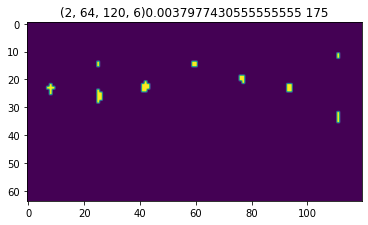

In [167]:
plt.imshow(np.max(positive_maps[0][0], -1))
plt.title(str(positive_maps[0].shape)+ str(np.mean(positive_maps[0][0]))+ ' ' + str(np.sum(positive_maps[0][0])))

In [168]:
pmap0 = np.array(Image.fromarray(np.max(positive_maps[0][0],-1)).resize((image_width, image_height)))
pmap1 = np.array(Image.fromarray(np.max(positive_maps[1][0],-1)).resize((image_width, image_height)))
pmap2 = np.array(Image.fromarray(np.max(positive_maps[2][0],-1)).resize((image_width, image_height)))
#pmap3 = np.array(Image.fromarray(np.max(positive_maps[3][0],-1)).resize((image_width, image_height)))
#pmap4 = np.array(Image.fromarray(np.max(positive_maps[4][0],-1)).resize((image_width, image_height)))
pmap0 = pmap0.astype(np.uint8)
pmap1 = pmap1.astype(np.uint8)
pmap2 = pmap2.astype(np.uint8)
pmap3 = 0#pmap3.astype(np.uint8)
pmap4 = 0#pmap4.astype(np.uint8)

Text(0.5, 1.0, '0.030989583333333334')

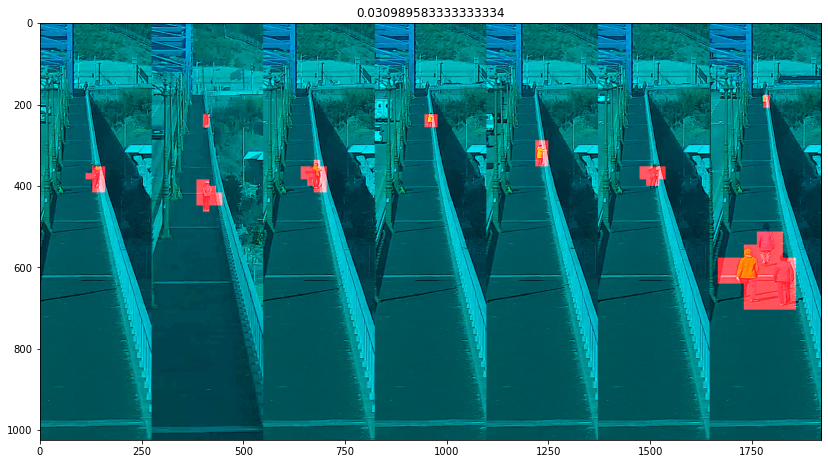

In [169]:
pmap_with_img = np.array(img_check)[0]#*255
pmap_with_img = pmap_with_img.astype(np.uint8)
pmap_add = np.expand_dims(pmap0+pmap1+pmap2+pmap3+pmap4, -1)
pmap = (pmap_add>0).astype(np.uint8)*255
mix_rgb = np.concatenate((pmap, pmap_with_img[:,:,1:]),-1)
plt.figure(figsize=(14,14))
plt.imshow(mix_rgb)
plt.title(str(np.mean(pmap_add)))

In [170]:
def load_weight():   
    weights_dir = path_weight#"data"
    #latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    latest_checkpoint = weights_dir 
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(weights_dir)

In [171]:
num_classes, num_classes_real, len(class_names)

(30, 5, 5)

In [172]:
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [173]:
num_classes, use_pedestrian

(30, False)

In [174]:
#optimizer = tf.optimizers.SGD(learning_rate=1e-5, momentum=0.1, clipvalue=5.)#warm up clipvalue=10. !

with strategy.scope():
    optimizer = tf.optimizers.SGD(learning_rate=1e-4, momentum=0.001)
    loss_detect = RetinaNetLoss(num_classes)
    model = createRetinaNet(num_classes, anchor_k)
    metrics_detect = [recall, precision, acc]#, gender_acc, body_acc, up_cloth_acc]
    losses = {"detect": loss_detect, 'segment': SegmentLoss(seg_k)} #dual
    metrics = {"detect": metrics_detect, 'segment': seg_acc} 
    if use_pedestrian:
        metrics = [recall, precision, acc, gender_acc, body_acc, up_cloth_acc]
    model.compile(loss=losses, optimizer=optimizer, metrics=metrics)
    callbacks_list = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=path_weight,
            monitor="loss",
            save_best_only=False,
            save_weights_only=True,
            verbose=0,
            save_freq=200
        )
    ]

RetinaNetClassificationLoss 5
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

In [175]:
model.summary()#5,743,728

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, None, None,  6542743     input_1[0][0]                    
__________________________________________________________________________________________________
a55 (Conv2D)                    (None, None, None, 2 69888       functional_1[0][3]               
__________________________________________________________________________________________________
a44 (Conv2D)                    (None, None, None, 2 41216       functional_1[0][2]               
_______________________________________________________________________________________

In [176]:
with strategy.scope():
    load_weight()

latest_checkpoint weight/pedestrian_efficientDet-D4


In [177]:
print(len(input_list_train), len(input_list_test))#990 2857, 1170 3128

62 25


In [178]:
'''
resnet-34  81ms/step, resnet-24  53ms/step
efficientB0  :      63ms/step - loss: 1.5916 - recall: 0.9155 - precision: 0.9330 - accuracy: 0.8751
eff-D7 Freeze:     182ms/step - loss: 2.1849 - recall: 0.9470 - precision: 0.9660 - accuracy: 0.9055 - flip_accuracy: 0.0052
eff-D2 finetu:  74s 74ms/step - loss: 4.5865 - recall: 0.8719 - precision: 0.8843 - acc: 0.9773
eff-D3 finetu:  74s 74ms/step - loss: 1.5638 - recall: 0.8632 - precision: 0.8382 - acc: 0.8657
        7s 75ms/step - loss: 3.3875 - recall: 0.8686 - precision: 0.8915 - acc: 0.8226       
       76s 76ms/step - loss: 1.9485 - recall: 0.9110 - precision: 0.7519 - acc: 0.9157 - gender_acc: 0.0000e+00 - body_acc: 0.0000e+00 - up_cloth_acc: 0.0000e+00
       75s 75ms/step - loss: 1.6430 - recall: 0.9019 - precision: 0.8985 - acc: 0.9158
       47s 95ms/step - loss: 6.2153 - recall: 0.8751 - precision: 0.7636 - acc: 0.6846 - gender_acc: 0.0000e+00 - body_acc: 0.0000e+00 - up_cloth_acc: 0.0000e+00
eff-D4 finetu:  91s 91ms/step - loss: 5.0720 - recall: 0.9431 - precision: 0.9585 - acc: 0.8279
                94s 94ms/step - loss: 5.1074 - recall: 0.9305 - precision: 0.9534 - acc: 0.8580
                92s 92ms/step - loss: 4.8367 - recall: 0.9479 - precision: 0.9499 - acc: 0.8953
                91s 91ms/step - loss: 4.1858 - recall: 0.9607 - precision: 0.9634 - acc: 0.9380
                91s 91ms/step - loss: 4.7158 - recall: 0.9549 - precision: 0.9593 - acc: 0.9337
                94s 94ms/step - loss: 4.8432 - recall: 0.9673 - precision: 0.9662 - acc: 0.9108 - gender_acc: 0.4118 - body_acc: 0.0000e+00 - up_cloth_acc: 0.0000e+00
                92s 92ms/step - loss: 5.1396 - recall: 0.9585 - precision: 0.9536 - acc: 0.9400
''' 
out = model.evaluate(val_dataset.take(13))

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
Base Loss Tensor("RetinaNetLoss/div_no_nan:0", shape=(None,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)
Segment Loss Tensor("SegmentLoss/SelectV2:0", shape=(None,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)
Base Loss Tensor("replica_1/RetinaNetLoss/div_no_nan:0", shape=(None,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:1)
Segment Loss Tensor("replica_1/SegmentLoss/SelectV2:0", shape=(None,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:1)
Base Loss Tensor("RetinaNetLoss/div_no_nan:0", shape=(None,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)
Segment Loss Tensor("SegmentLoss/SelectV2:0", shape=(None,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)
Base Loss Tensor("replica_1/RetinaNetLoss/div_no_nan:0", shape=(None,), dtype=float32, device=/job:localhost/replica:0/ta

In [179]:
epochs = 1000
hist = model.fit(train_dataset, epochs=epochs,  callbacks=callbacks_list, verbose=1)
'''
effD2 Freeze:32s 474ms/step - loss: 14.7472 - recall: 0.4458 - precision: 0.6697 - accuracy: 0.0049
effD2 fine :269s 544ms/step - loss: 9.3350 - recall: 0.9176 - precision: 0.9638 - acc: 0.9910
effD3 Freeze : 171s 546ms/step - loss:15.9819 - recall: 0.8651 - precision: 0.6972 - acc: 0.9518 - gender_acc: 0.5927 - body_acc: 0.5747 - up_cloth_acc: 0.3175
        fine : 110s 565ms/step - loss: 4.3338 - recall: 0.8358 - precision: 0.8073 - acc: 0.8943               
                267s 558ms/step - loss: 8.0857 - recall: 0.9356 - precision: 0.9513 - acc: 0.9390 - gender_acc: 0.6069 - body_acc: 0.5565 - up_cloth_acc: 0.3009
                1239s 521ms/step - loss: 2.2392 - recall: 0.8902 - precision: 0.9115 - acc: 0.9087
effD4 Freeze : 123s 796ms/step - loss: 53.2804 - recall: 0.5714 - precision: 0.6422 - acc: 0.4137 - gender_acc: 0.5843 - body_acc: 0.5230 - up_cloth_acc: 0.2131
      fine   :2076s 655ms/step - loss: 23.4933 - recall: 0.8588 - precision: 0.8985 - acc: 0.7531 - gender_acc: 0.5944 - body_acc: 0.5476 - up_cloth_acc: 0.2677
              1536s 651ms/step - loss: 5.4101 - recall: 0.9451 - precision: 0.9601 - acc: 0.8175
suppre bgcls  1898s 670ms/step - loss: 6.5129 - recall: 0.9479 - precision: 0.9588 - acc: 0.8418
               150s 649ms/step - loss: 4.3950 - recall: 0.9686 - precision: 0.9769 - acc: 0.9347
               1829/Unknown - 1224s 669ms/step - loss: 25.7655 - recall: 0.9261 - precision: 0.9402 - acc: 0.7992
'''

Epoch 1/1000
Base Loss Tensor("RetinaNetLoss/div_no_nan:0", shape=(None,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)
Segment Loss Tensor("SegmentLoss/SelectV2:0", shape=(None,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)
Base Loss Tensor("replica_1/RetinaNetLoss/div_no_nan:0", shape=(None,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:1)
Segment Loss Tensor("replica_1/SegmentLoss/SelectV2:0", shape=(None,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:1)
INFO:tensorflow:batch_all_reduce: 354 all-reduces with algorithm = nccl, num_packs = 1
Base Loss Tensor("RetinaNetLoss/div_no_nan:0", shape=(None,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)
Segment Loss Tensor("SegmentLoss/SelectV2:0", shape=(None,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)
Base Loss Tensor("replica_1/RetinaNetLoss/div_no_nan:0", shape=(None,), dtype=float32, device=/job:loca

KeyboardInterrupt: 

In [180]:
model.save_weights(path_weight)
path_weight

'weight/pedestrian_efficientDet-D4'

In [181]:
#image = tf.keras.Input(shape=[padded_image_shape[0], padded_image_shape[1], 3], name="image")
image = tf.keras.Input(shape=[None, None, 3], name="image")
model_out = model(image, training=False)
print('predictions', type(model_out), model_out.keys())
predictions = model_out['detect']
segment_h = model_out['segment']
segment_cls = tf.argmax(segment_h, -1)

detections = decodePredictions(image, predictions, confidence_threshold=0.5, nms_iou_threshold=0.2)
inference_model = tf.keras.Model(inputs=image, outputs=[detections, segment_cls])

predictions <class 'dict'> dict_keys(['detect', 'segment'])


In [182]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(12, 10), linewidth=1, color=[0, 0, 1], 
    boxes_gt=None):
    
    image = np.array(image, dtype=np.uint8)
    image = attach_crop_image(image, boxes, max_crop=200)        
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()        
   
    if boxes_gt is not None:
        for box in boxes_gt:        
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            patch = plt.Rectangle(
                [x1, y1], w, h, fill=False, edgecolor=[0,1,0], linewidth=2
            )
            ax.add_patch(patch)
            
    for box, cls, score in zip(boxes, classes, scores):        
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        
        if cls == 3:
            color = [1, 0, 0]
        elif cls == 1:
            color = [1, 1, 1]
        else:
            color = [0, 0, 1]
            
        color_text = color#edgecolors[cls]
        
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 100:
            score_txt = str.format('(%d)%.2f' %(cls, score))
            ax.text(x1, y1, score_txt, bbox={"facecolor": color_text, "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
          
    plt.show()
    return ax

In [187]:
def check_test(test_datas, bboxs_label, step=1):
    i = 0
    for image, segmap, cbbox in test_datas: 
        
        if i%step==0:            
            bbox_annotation = bboxs_label[i]
            scale = np.array(image.shape[:2])[::-1]
            scale = np.reshape(scale, [1, 2])
            scale = np.concatenate((scale, scale), 1)
            gt_bbox = bbox_annotation[ :, :4] * scale
           
            input_image, _, ratio = resize_and_pad_image(image, jitter=None)
            input_image = tf.expand_dims(input_image, axis=0)
            #input_image = tf.cast(input_image, tf.uint8)
            model_out = inference_model.predict(input_image)
            print('detected_box', type(model_out))
            detected_box = model_out[0]            
            seg_h = (model_out[1][0]).astype(np.float32)                        
            seg_h = (seg_h / seg_k * 255).astype(np.uint8)
                        
            print(input_image.shape, seg_h.shape, np.mean(seg_h), 'detected_box', detected_box.shape, scale, 'ratio',ratio)
            #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio
            #plt.imshow(seg_h)
            #break
            visualize_detections(
                image,
                box,
                cls_h,
                scores,
                boxes_gt=gt_bbox
            )
        i+=1

detected_box <class 'list'>
(1, 1024, 1920, 3) (1024, 1920) 127.09362233479818 detected_box (1, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)


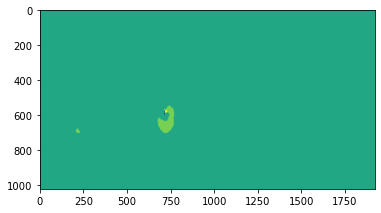

In [184]:
check_test(dataset_test, bbox_list_test, step=100)

detected_box <class 'list'>
(1, 1024, 1920, 3) (1024, 1920) 127.09362233479818 detected_box (1, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)


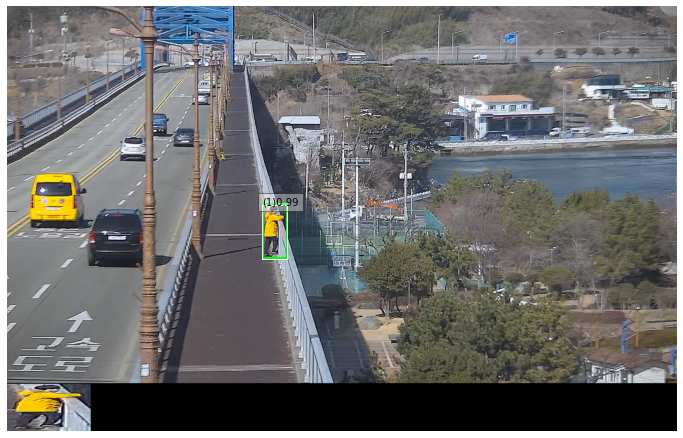

In [188]:
check_test(dataset_test, bbox_list_test, step=100)

In [ ]:
#random indexing for train
check_test(dataset, bbox_list_train, step=200)

In [ ]:
def check_wrong(X, Y, annot):
    i=0
    for ann in annot:
        image, y = X[i], Y[i]
        #print('ann', ann)            
        i+=1
        
        scale = np.array(image.shape[:2])[::-1]
        scale = np.reshape(scale, [1, 2])
        scale = np.concatenate((scale, scale), 1)
        gt_bbox = y[ :, :4] * scale
        #gt_bbox = y[:, 1:1+4]
        input_image, _, ratio = resize_and_pad_image(image, jitter=None)
        input_image = tf.expand_dims(input_image, axis=0)
        #input_image = tf.cast(input_image, tf.uint8)
        detected_box = inference_model.predict(input_image)
        if len(detected_box)>len(y):
            print('ann', ann)
            print('detected_box', detected_box.shape, 'gt', len(y))
            #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio

            visualize_detections(
                image,
                box,
                cls_h,
                scores,
                boxes_gt=gt_bbox
            )

In [ ]:
check_wrong(input_list, bbox_list, annotation)

In [ ]:
def add_pad_32x_arr(image_arr):
    #print('image_arr', image_arr.shape, image_arr.dtype)
    stride = 32
    img_h = image_arr.shape[0]
    img_w = image_arr.shape[1]
    img_c = image_arr.shape[2]
    #print('add_pad_32x', image_arr.shape, img_h, img_w)
    pad_h = (stride - (img_h % stride)) % stride
    pad_w = (stride - (img_w % stride)) % stride
    padded_h = img_h + pad_h
    padded_w = img_w + pad_w
    #print('pad_h', pad_h, 'pad_w', pad_w)
    image_padded = np.zeros((padded_h, padded_w, img_c), dtype=np.uint8)
    image_padded[:img_h, :img_w] = image_arr
        
    return image_padded

In [ ]:
def check_bg(image, is_display=True, is_save=False, save_path=''):
    scale = np.array(image.shape[:2])[::-1]
    scale = np.reshape(scale, [1, 2])
    scale = np.concatenate((scale, scale), 1)

    #input_image, _, ratio = resize_and_pad_image(image, jitter=None)
    input_image = add_pad_32x_arr(image)     
    ratio = 1
    input_image = tf.expand_dims(input_image, axis=0)

    detected_box = inference_model.predict(input_image)        
    if len(detected_box) > 0:
        #print(input_image.shape, 'detected_box', detected_box.shape, scale, 'ratio',ratio)
        #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
        if is_display:
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio

            visualize_detections(
                image,
                box,
                cls_h,
                scores                
            )
        if is_save:
            img = Image.fromarray(image)
            img.save(save_path +'.jpg')
        else:
            pass
    return int(len(detected_box)>0)

In [ ]:
list_jpg = glob(folder_water_bg + '*')
print(len(list_jpg))

In [ ]:
wrong = 0
for i in range(0, len(list_jpg)//1):    
    jpg = list_jpg[i]
    #print('i', i, jpg.split(os.sep)[-1])
    img = Image.open(jpg)
    arr = np.array(img)
    
    n = check_bg(arr, is_display=True)
    if n>0:
        wrong += n
        print(wrong, i, jpg)#414/815, 348/544, 6/242, 43/1522, 59/2043, 64/2375

## video inference, save result
1. split image from video
1. get target image paths
1. inference, save result to list
1. save as csv format

In [ ]:
import cv2
import time
def video_to_frames(input_loc, stride=1):
    """Function to extract frames from input video file
    and save them as separate frames in an output directory.
    Args:
        input_loc: Input video file.
        output_loc: Output directory to save the frames.
    Returns:
        None
    """
        
    folder_split = input_loc.split(os.sep)
    file_name = folder_split[-1]
    file_name = file_name.split('.')[0]
    output_loc = os.sep.join(folder_split[:-1]) + os.sep + file_name + os.sep    
    print('output_loc', output_loc)
        
    try:
        os.mkdir(output_loc)
    except OSError:
        pass
    # Log the time
    time_start = time.time()
    # Start capturing the feed
    cap = cv2.VideoCapture(input_loc)
    # Find the number of frames
    
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    save_count = 0
    print ("Converting video..\n")
    # Start converting the video
    
    while cap.isOpened():
        # Extract the frame
        ret, frame = cap.read()
        count = count + 1        
        file_name = "%#05d.jpg" % (count+1)        
        dst_name = output_loc + file_name
        
        try:
            cv2.imwrite(dst_name, frame)
            #b, g, r = np.split(frame, 3, -1)
            #rgb = np.concatenate((r,g,b), -1)        
            save_count += 1
        except:
            print('except', cap, ret, frame, dst_name)
            break
        
        # If there are no more frames left
        if count%100==0:
            print('count', video_length, count, save_count)
       
    time_end = time.time()
    # Release the feed
    cap.release()
    # Print stats
    print ("Done extracting frames.\n%d frames extracted" % count)
    print ("It took %d seconds to save %d for conversion ." % (time_end-time_start, save_count))
    return output_loc

In [ ]:
path_avi = '/home/mvlab/Videos/미수_스마트시티_통영대교_미수방향1(Ch 01)_[20201217]140000-[20201217]141000(20201217_140001).avi'
os.path.isfile(path_avi)

In [ ]:
output_loc = video_to_frames(path_avi)

In [ ]:
#                                미수_스마트시티_통영대교_미수방향1(Ch 01)_[20201217]135000-[20201217]140000(20201217_135001)
output_loc = '/home/mvlab/Videos/미수방향1_2/'
os.path.isdir(output_loc)

In [ ]:
#paths_test_img = glob('/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/event/*미수방향1*/*.jpg')
paths_test_img = glob(output_loc + '*')
print(len(paths_test_img), output_loc)
paths_test_img = np.sort(paths_test_img)

In [ ]:
def convert_label_list_to_df(list_output):
    print('convert_label_list_to_df')
    df = pd.DataFrame(columns=['path', 'cls', 'x0', 'y0', 'x1', 'y1', 'confidence'])
    
    ratio = 0.9481481481481482
    for output in list_output:
        path_img = output[0]
        detected_box = output[1]

        for box in detected_box:
            cls_h = box[0].astype(np.int)
            scores = (box[1]*100).astype(np.int)
            box_coord = box[2:2+6]/ratio
            x0 = box_coord[0].astype(np.int)
            y0 = box_coord[1].astype(np.int)
            x1 = box_coord[2].astype(np.int)
            y1 = box_coord[3].astype(np.int)
            row = {'path':path_img, 'cls':cls_h, 'x0':x0, 'y0':y0, 'x1':x1, 'y1':y1, 'confidence':scores}
            df = df.append(row, ignore_index=True)
            
    return df

def save_inference_result(paths_img):
    
    print('len', len(paths_img))
    
    list_output = []
    for i in range(len(paths_img)):
        path_img = paths_img[i]
        if i % 100 == 0:
            print(len(paths_img), i, path_img.split(os.sep)[-1])
        
        img = Image.open(path_img)
        img_arr = np.array(img)
        input_image, _, ratio = resize_and_pad_image(img_arr, jitter=None)
        input_image = tf.expand_dims(input_image, axis=0)        
        detected_box = inference_model.predict(input_image)
        
        if len(detected_box) > 0:            
            list_output.append([path_img, detected_box])
        
        if len(list_output) > 0 and len(list_output)%1000==0:
            df = convert_label_list_to_df(list_output)            
            df.to_csv('predict_temp.csv')
    
    df = convert_label_list_to_df(list_output)            
    df.to_csv('predict.csv')
    print('finished')


In [ ]:
save_inference_result(paths_test_img[:])

## Freeze Model

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [ ]:
 # Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: inference_model(x))
full_model = full_model.get_concrete_function(
    x=tf.TensorSpec(inference_model.inputs[0].shape, inference_model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]


In [ ]:
print('inputs', type(frozen_func.inputs), len(frozen_func.inputs), frozen_func.inputs)
print('outputs', type(frozen_func.outputs), len(frozen_func.outputs), frozen_func.outputs)

In [ ]:
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="pedestrian_efficientSeg-D4_frozen_graph.pb",
                  as_text=False)

In [ ]:
def check_error(X, Y, Path, step=1):
    
    for i in range(len(X)): 
        image = X[i]
        bbox_annotation = Y[i]
        path = Path[i]
        
        scale = np.array(image.shape[:2])[::-1]
        scale = np.reshape(scale, [1, 2])
        scale = np.concatenate((scale, scale), 1)
        gt_bbox = bbox_annotation[:, 1:] * scale

        input_image, _, ratio = resize_and_pad_image(image, jitter=None)
        input_image = tf.expand_dims(input_image, axis=0)

        detected_box = inference_model.predict(input_image)
        detect_k = len(detected_box)
        if detect_k!= len(bbox_annotation):
            print(path, input_image.shape, 'detected_box', detected_box.shape, scale, 'ratio',ratio.numpy())
            #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio
            #print('box', box)

            visualize_detections(
                image,
                box,
                cls_h,
                scores,
                boxes_gt=gt_bbox
            )
        

In [ ]:
start = 1000
end = start + 100
check_error(input_list[start:end], bbox_list[start:end], path_list[start:end])

## load model from .pb file

In [ ]:
saved_model_pb = './pedestrian_efficientDet-D2'

In [ ]:
inference_model.save(saved_model_pb)

In [ ]:
custom_objects = {'recall':recall,'precision':precision}
model_loaded = keras.models.load_model(saved_model_pb, custom_objects=custom_objects, compile=False)
#model_loaded.summary()

In [ ]:
model_loaded.compile()

In [ ]:
for image, cbbox in val_dataset: 
    
    detected_box = model_loaded.predict(image)
    print('detected_box', detected_box.shape)
    if len(detected_box) > 0:
        cls_h = detected_box[:, 0].astype(np.int)
        scores = detected_box[:, 1]
        box = detected_box[:, 2:]

        visualize_detections(
            image[0],
            box,
            cls_h,
            scores
        )    
    break

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_pb)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter

In [ ]:
tflite_model = converter.convert()

In [ ]:
# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!ls *.tflite

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()

In [ ]:
# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
input_details, output_details

In [ ]:
input_data = input_list_train[0]
input_data = (np.expand_dims(input_data, 0)/255).astype(np.float32)
input_data.shape

In [ ]:
input_data = input_data[:, :padded_image_shape[0], :padded_image_shape[1]]
input_data.shape, np.max(input_data)

In [ ]:
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
print('input_data', input_data.shape)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
tflite_results.shape

In [ ]:
tflite_results[0]

In [ ]:
detected_box = tflite_results
cls_h = detected_box[:, 0].astype(np.int)
scores = detected_box[:, 1]
box = detected_box[:, 2:] / ratio
#print('box', box)

visualize_detections(
    input_data[0]*255,
    box,
    cls_h,
    scores,
)

In [ ]:
glob('/home/mvlab/Downloads/dataset/통영/label_noise/*')